# RNAseq analysis of _D. novameixcana_ females after con- and heterospecific mating

## Introduction

The data files used in this analysis were generated within a Snakemake workflow. Breifly, RNAseq reads were generated from _D. novamexicana_ female samples (heads, ovaries, reproductive tracts, and gonadecotmized abdomen + thorax) that were either from mated females or virgin females. In addition, male _D. novamexicana_ RNAseq reads from a previous study were included in the analysis. First, reads were mapped to the virilis genome (dvir1.06) with HISAT and abundance estimates were derived. Second, the transcriptome structure produced by the genome mapping was utilized in making a canonical genome-based transcriptome that was also queried for abundance with eXpress. Finally, mapped and unmapped reads were used to generate a genome-guided transcriptome assembly and a _de novo_ transcriptome assembly, respectively, using Trinity. Transcripts from both Trinity runs were merged and abundance estimates for the samples were obtained using eXpress. 

The Trinity transcriptome was used to generate a Trinotate annotation. A similar annotation for the genome-based transcriptome was available from a previous study (Ahmed-Braimah _et al._ 2017). The workflow for these analyses is illustrated below.

<img src="Misc/workflow.png" alt="Drawing" style="width: 1500px;"/>

#### Packages and functions:

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. First load the packages:

In [1]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "heatmap3", "imager", "pheatmap", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyverse",
                 "wesanderson", "VennDiagram", "viridis")

invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

# The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))


... and the custom functions are in a file:

In [2]:
source("Functions.R")

Suppres excessive VennDiagram's log files:

In [3]:
invisible(futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger"))

There are auxiliary files that need to be created from the raw input files. These processes are executed through a shell script, that we can run like so:

In [4]:
# system('./Misc/initial_file_modifications.sh')

#### Annotation files:

A Trinotate report and accompanying Gene Ontology assignments were produced for the genome-based transcriptome and the Trinity transcriptome. Load those here:

In [5]:
trinotate_annotated = read.csv("Trinotate/Annotated/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

trinotate_pasa = read.csv("Trinotate/PASA/Trinotate_report_with_description_column.xls", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

From these reports we also extracted the Gene Ontology (GO) assignments for each gene whenever possible:

In [6]:
GOinfo_annotated = read.table("Trinotate/Annotated/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

GOinfo_pasa = read.table("Trinotate/PASA/Trinotate_report.xls.gene_ontology", header=F, row.names=1,stringsAsFactors=F)

For the genome data the gene IDs were FlyBase gene names (FBgn..), and we have a file that matches their gene names and coordinates:

In [7]:
dv1.06_features = read.table("Annotations/Genome-based/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we have information on orthology to _D. melanogaster_:

In [8]:
melOrths = read.table(file = "Annotations/Genome-based/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

We created a features table for the StringTie assembled transcripts:

In [9]:
gene.features = read.csv("StringTie/features.txt", sep = "\t")

We'll need the gene-to-transcript mapping for the annotated transcripts:

In [10]:
FBgn_to_FBtr = read.csv("gffread_annotated_transcriptome/gffread_annotated_transcripts.gene_trans_map", header = F, sep = "\t")
colnames(FBgn_to_FBtr) = c("FBgn_ID", "FBtr_ID")

For the edgeR DGE object, we can add annotation features for easy querying. We'll just need to do this for the Pasa data here:

In [11]:
tTrinotate.sub = unique(subset(trinotate_pasa, select = c("gene_id", "dvir1.06.BLASTX", "sprot_Top_BLASTX_hit_description")))

gene_to_transcript_to_ref = unique(subset(gene.features, select=c("gene_id", "transcript_id", "ref_gene_id")))

all.features = merge(dv1.06_features, gene_to_transcript_to_ref, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

tTrinotate.sub.all = merge(all.features, tTrinotate.sub, by.x = "transcript_id", by.y = "dvir1.06.BLASTX", all = T)

tTrinotate.sub.all = unique(subset(tTrinotate.sub.all, select=c("gene_id.y", "gene_id.x", "gene_name", "FBgn_ID", "chromosome", "min", "max", "sprot_Top_BLASTX_hit_description")))

tTrinotate.sub.all = subset(tTrinotate.sub.all, !is.na(gene_id.y))

tTrinotate.sub.some = unique(subset(tTrinotate.sub.all, select = c("gene_id.y", "gene_id.x", "gene_name", "sprot_Top_BLASTX_hit_description")))

Finally, from our previous study (Ahmed-Braimah _et al._ 2017), we'll load the male-biased genes:

In [12]:
male_tissue.biased_gene_factors = read.csv("Annotations/Genome-based/male-tissue.biased-gene-factors.txt", header = T, sep = "\t")
SFPs = filter(male_tissue.biased_gene_factors, status == "SFP")$FBgn_ID
AG_biased = filter(male_tissue.biased_gene_factors, status == "AG-biased")$FBgn_ID
EB_biased = filter(male_tissue.biased_gene_factors, status == "EB-biased")$FBgn_ID
TS_biased = filter(male_tissue.biased_gene_factors, status == "TS-biased")$FBgn_ID

#### Expression files

There are two raw count matrices derived from each of the mapping/abundance steps described above. We'll load each of these:

In [13]:
counts_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)
counts_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

For each the counts generated by eXpress there're normalized expression matrices in TPM units (we'll have to normalize the counts derived from HISAT2). Load those:

In [14]:
tpm_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)
tpm_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

We'll need the Trinity gene lengths:

In [15]:
pasa_trans_lengths = read.table("Trinity/pasa/bt2_reference/pasa_transcript_lengths.txt", header = T)

pasa_trans_map = read.table("Trinity/pasa/bt2_reference/compreh_init_build.geneToTrans_mapping", header = F)

pasa_gene_lengths = as.data.table(subset(merge(pasa_trans_lengths, pasa_trans_map, by.x = "transcript_id", by.y = "V2"), select = c("length", "V1")))
colnames(pasa_gene_lengths) = c("length", "gene_id")
pasa_gene_lengths = as.data.frame(pasa_gene_lengths[pasa_gene_lengths[, .I[which.max(length)], by=gene_id]$V1])
rownames(pasa_gene_lengths) <- pasa_gene_lengths$gene_id
pasa_gene_lengths = subset(pasa_gene_lengths, select = "length")

Also load the annotated gene lengths, which we've saved from a previous study:

In [16]:
a.gene_lengths = read.table("Annotations/Genome-based/FBgn_lengths.txt", header=T, row.names=1)

#### Miscellaneous files:

For the differential expression analysis we will need the sample-to-replicate mapping and any additional sample information:

In [17]:
sampleData = read.table("Misc/samples.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]

From the above we can produce a detailed sample information object:

In [18]:
sampleInfo = sampleData
colnames(sampleInfo) = c("SampleName", "Replicate")

sampleInfo$Sex = ifelse(grepl("Female",sampleInfo$SampleName), "female", "male")

sampleInfo$Tissue = ifelse(grepl("RT",sampleInfo$Replicate), "repTract", ifelse(grepl("_H_",sampleInfo$Replicate), "head", ifelse(grepl("_OV_",sampleInfo$Replicate), "ovaries", ifelse(grepl("_CR_",sampleInfo$Replicate), "carcass", ifelse(grepl("AG",sampleInfo$Replicate), "acGlnds", ifelse(grepl("EB",sampleInfo$Replicate), "ejBulb", "testes"))))))

sampleInfo$Status = ifelse(grepl("Female_C", sampleInfo$Replicate) | grepl("Male", sampleInfo$Replicate), "conspecific", ifelse(grepl("Female_V", sampleInfo$Replicate), "virgin", "heterospecific"))

sampleInfo$Time = ifelse(grepl("Female_V", sampleInfo$SampleName), "virgin", ifelse(grepl("3", sampleInfo$SampleName), "3hpm", ifelse(grepl("6",sampleInfo$SampleName), "6hpm", ifelse(grepl("12",sampleInfo$SampleName), "12hpm", "24hpm"))))

Because we're using both the genome- and trinity-based expression data, it would be convenient to compare the results between both analyses. For that we made a BLAST file between transcripts of both strategies (header line added manually). We also made perform a recirpocal BLAST search between the two transcript sets. We'l load those here:

In [19]:
pasa_v_annotated_blast = read.table("Misc/BLASTn.pasa_vs_annotated.outfmt6", header = T, sep = "\t")
pasa_v_genome_blast = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6.txt", header = T, sep = "\t")
pasa_v_genome_blast_sub = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6_one_to_one.txt", header = F, sep = "\t")
pasa_v_genome_rbh = read.table("Misc/dvir1.06_v_pasa.RBH.tsv", header = T, sep = "\t")

We also have useful population genetic data from a previous study that we can use later on:

In [20]:
paml.data = read.csv(file = "Annotations/Genome-based/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
KaKs.data = read.csv(file = "Annotations/Genome-based/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)

We also generated a new set which includes D. montana:

In [21]:
RT_paml.data = read.csv("Results/PopGen/ANLVM.paml.brSt.RT_results_mod.txt", header = T, sep = "\t")
RT_paml.data = tidyr::spread(RT_paml.data, Sample, lnL)

RT_paml.omega.data = read.csv("Results/PopGen/ANLVM.paml.omega.RT_results_mod.txt", header = T, sep = "\t")
colnames(RT_paml.omega.data) = c("FBtr_ID", "omega")

RT_paml.data = merge(RT_paml.data, RT_paml.omega.data, by.x = "FBtr_ID", by.y = "FBtr_ID", all = T)
rm(RT_paml.omega.data)

RT_KaKs.data = read.csv(file = "Results/PopGen/ANLVM.pairwise.KaKs.RT_results.txt", header = T, sep = "\t", check.names = F)

In [22]:
AG_paml.data = read.csv("Results/PopGen/ANLVM.paml.brSt.AG_results_mod.txt", header = T, sep = "\t")
AG_paml.data = tidyr::spread(AG_paml.data, Sample, lnL)

AG_paml.omega.data = read.csv("Results/PopGen/ANLVM.paml.omega.AG_results_mod.txt", header = T, sep = "\t")
colnames(AG_paml.omega.data) = c("FBtr_ID", "omega")

AG_paml.data = merge(AG_paml.data, AG_paml.omega.data, by.x = "FBtr_ID", by.y = "FBtr_ID", all = T)
rm(AG_paml.omega.data)

AG_KaKs.data = read.csv(file = "Results/PopGen/ANLVM.pairwise.KaKs.AG_results.txt", header = T, sep = "\t", check.names = F)

We'll calculate the LRT for this new PAML dataset:

In [23]:
#### Calaculate LRT, pValues and FDR for RT_paml data
RT_paml.data$Damr_LRT = 2*(RT_paml.data$Damr_ML95_H1 - RT_paml.data$Damr_ML95_H0)
RT_paml.data$Damr_pValue = pchisq(q = RT_paml.data$Damr_LRT, df = 1, lower.tail = F)
RT_paml.data$Damr_FDR = p.adjust(p = RT_paml.data$Damr_pValue, method = "fdr")

RT_paml.data$Dlum_LRT = 2*(RT_paml.data$Dlum_LM8_H1 - RT_paml.data$Dlum_LM8_H0)
RT_paml.data$Dlum_pValue = pchisq(q = RT_paml.data$Dlum_LRT, df = 1, lower.tail = F)
RT_paml.data$Dlum_FDR = p.adjust(p = RT_paml.data$Dlum_pValue, method = "fdr")

RT_paml.data$Dnov_LRT = 2*(RT_paml.data$Dnov_4_H1 - RT_paml.data$Dnov_4_H0)
RT_paml.data$Dnov_pValue = pchisq(q = RT_paml.data$Dnov_LRT, df = 1, lower.tail = F)
RT_paml.data$Dnov_FDR = p.adjust(p = RT_paml.data$Dnov_pValue, method = "fdr")

RT_paml.data$Dvir_LRT = 2*(RT_paml.data$Dvir_S9_H1 - RT_paml.data$Dvir_S9_H0)
RT_paml.data$Dvir_pValue = pchisq(q = RT_paml.data$Dvir_LRT, df = 1, lower.tail = F)
RT_paml.data$Dvir_FDR = p.adjust(p = RT_paml.data$Dvir_pValue, method = "fdr")

RT_paml.data$Dmon_LRT = 2*(RT_paml.data$Dmon_Oul_H1 - RT_paml.data$Dmon_Oul_H0)
RT_paml.data$Dmon_pValue = pchisq(q = RT_paml.data$Dmon_LRT, df = 1, lower.tail = F)
RT_paml.data$Dmon_FDR = p.adjust(p = RT_paml.data$Dmon_pValue, method = "fdr")

In [24]:
#### Calaculate LRT, pValues and FDR for AG_paml data
AG_paml.data$Damr_LRT = 2*(AG_paml.data$Damr_ML95_H1 - AG_paml.data$Damr_ML95_H0)
AG_paml.data$Damr_pValue = pchisq(q = AG_paml.data$Damr_LRT, df = 1, lower.tail = F)
AG_paml.data$Damr_FDR = p.adjust(p = AG_paml.data$Damr_pValue, method = "fdr")

AG_paml.data$Dlum_LRT = 2*(AG_paml.data$Dlum_LM8_H1 - AG_paml.data$Dlum_LM8_H0)
AG_paml.data$Dlum_pValue = pchisq(q = AG_paml.data$Dlum_LRT, df = 1, lower.tail = F)
AG_paml.data$Dlum_FDR = p.adjust(p = AG_paml.data$Dlum_pValue, method = "fdr")

AG_paml.data$Dnov_LRT = 2*(AG_paml.data$Dnov_4_H1 - AG_paml.data$Dnov_4_H0)
AG_paml.data$Dnov_pValue = pchisq(q = AG_paml.data$Dnov_LRT, df = 1, lower.tail = F)
AG_paml.data$Dnov_FDR = p.adjust(p = AG_paml.data$Dnov_pValue, method = "fdr")

AG_paml.data$Dvir_LRT = 2*(AG_paml.data$Dvir_S9_H1 - AG_paml.data$Dvir_S9_H0)
AG_paml.data$Dvir_pValue = pchisq(q = AG_paml.data$Dvir_LRT, df = 1, lower.tail = F)
AG_paml.data$Dvir_FDR = p.adjust(p = AG_paml.data$Dvir_pValue, method = "fdr")

AG_paml.data$Dmon_LRT = 2*(AG_paml.data$Dmon_Oul_H1 - AG_paml.data$Dmon_Oul_H0)
AG_paml.data$Dmon_pValue = pchisq(q = AG_paml.data$Dmon_LRT, df = 1, lower.tail = F)
AG_paml.data$Dmon_FDR = p.adjust(p = AG_paml.data$Dmon_pValue, method = "fdr")

Let's combine those two for convenience:

In [25]:
AG_paml.data$status = "AG_biased"
RT_paml.data$status = "RT_biased"
paml2.data = rbind(AG_paml.data, RT_paml.data)

Also combine the pairwise KaKs data:

In [26]:
AG_KaKs.data$status = "AG_biased"
RT_KaKs.data$status = "RT_biased"
KaKs2.data = rbind(AG_KaKs.data, RT_KaKs.data)

Create lists of transcripts that have an LRT FDR value < 0.01:

In [27]:
Damr.lrt.sig = filter(paml2.data, Damr_FDR < 0.01)$FBtr_ID
Dnov.lrt.sig = filter(paml2.data, Dnov_FDR < 0.01)$FBtr_ID
Dlum.lrt.sig = filter(paml2.data, Dlum_FDR < 0.01)$FBtr_ID
Dvir.lrt.sig = filter(paml2.data, Dvir_FDR < 0.01)$FBtr_ID
Dmon.lrt.sig = filter(paml2.data, Dmon_FDR < 0.01)$FBtr_ID

[1] FBtr0233532 FBtr0236679 FBtr0437479 FBtr0434128 FBtr0434302 FBtr0435711
 [7] FBtr0437677 FBtr0439127 FBtr0439873 FBtr0443132 FBtr0443237 FBtr0443925
[13] FBtr0444074
1442 Levels: FBtr0226186 FBtr0226229 FBtr0226340 FBtr0226520 ... FBtr0443405.out:omega (dN/dS) = 999.00000

Let's check the overlap between those transcripts:

In [28]:
# temp_candidates <- list(Damr = Damr.lrt.sig, Dnov = Dnov.lrt.sig, Dlum = Dlum.lrt.sig, Dvir = Dvir.lrt.sig, Dmon = Dmon.lrt.sig)

# temp_Vdiag<-venn.diagram(temp_candidates, NULL, fill=c("#01aafb", "#d1004b", "green", "yellow", "orange"), alpha=c(0.75,0.75,0.75,0.75,0.75), cex = 3, cat.fontface= 6, cat.cex = 1, resolution = 100, )

# # temp_combs <- unlist(lapply(1:length(temp_candidates), function(j) combn(names(temp_candidates), j, simplify = FALSE)), recursive = FALSE)
# # names(temp_combs) <- sapply(temp_combs, function(i) paste0(i, collapse = ","))
# # temp_elements <- lapply(temp_combs, function(i) Setdiff(temp_candidates[i], temp_candidates[setdiff(names(temp_candidates), i)]))
    
# options(repr.plot.width = 5, repr.plot.height = 4)
# grid.arrange(gTree(children=temp_Vdiag))

For some entries we might want a unique 1-to-1 matching of gene ID's. We can do that like so:

In [29]:
fbgn_to_geneName = unique(subset(dv1.06_features, select = c("FBgn_ID", "gene_name")))
geneID_to_fbgn = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
IDz = merge(fbgn_to_geneName, geneID_to_fbgn, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

For the PASA transcripts, we can use the blast result to match pasa gene ids with their corresponding hisat2 gene id:

In [30]:
transcript.features = unique(subset(gene.features, select = c("transcript_id", "gene_id", "ref_gene_id")))

intFile1 = merge(pasa_v_genome_blast_sub, transcript.features, by.x = "V2", by.y = "transcript_id", all.x = T)

intFile2 = suppressWarnings(merge(intFile1, pasa_trans_map, by.x = "V1", by.y = "V2", all.x = T))
colnames(intFile2) = c("pasa_transcript_id", "hisat2_transcript_id", "hisat2_gene_id", "ref_gene_id", "pasa_gene_id")

intFile3 = unique(subset(intFile2, select = c("pasa_gene_id", "hisat2_gene_id")))

pasa_to_hisat2_mapping = aggregate(hisat2_gene_id~pasa_gene_id, data = intFile3, toString)

rm(intFile1, intFile2, intFile3)

We'll make a couple of TPM tables for gene level and heatmap plotting:

In [31]:
## For annotated bt2 data
TPMmatrix <- tpm_bt2.fbgn
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, fbgn_to_geneName, by.x = "gene_id", by.y = "FBgn_ID")
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.fbgn = subset(TPMmatrix.m, select = c("gene_id", "gene_name","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
colnames(tpmTable_bt2.fbgn) = c("FBgn_ID", "gene_name","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM")
rm(TPMmatrix.m, TPMmatrix)

tpmSE_bt2.fbgn = summarySE(tpmTable_bt2.fbgn, measurevar = "TPM", groupvars = c("FBgn_ID", "gene_name","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.fbgn, "Trinity/fbgn/eXpress/tpmSE_bt2.fbgn.txt", quote = F, sep = "\t", row.names = F)
# tpmSE_bt2.fbgn = read.table("Trinity/fbgn/eXpress/tpmSE_bt2.fbgn.txt", header = T, sep = "\t")

tmpMat<-cast(tpmSE_bt2.fbgn, FBgn_ID~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.fbgn <- tmpMat[,-1]
rownames(tpmMatrix_bt2.fbgn) <- tmpMat[,1]
rm(tmpMat)

In [32]:
## For pasa data
TPMmatrix <- tpm_bt2.pasa
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, pasa_to_hisat2_mapping, by.x = "gene_id", by.y = "pasa_gene_id", all.x = T)
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.pasa = subset(TPMmatrix.m, select = c("gene_id", "hisat2_gene_id","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
rm(TPMmatrix.m, TPMmatrix)

# tpmSE_bt2.pasa = summarySE(tpmTable_bt2.pasa, measurevar = "TPM", groupvars = c("gene_id", "hisat2_gene_id","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.pasa, "Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", quote = F, sep = "\t", row.names = F)
tpmSE_bt2.pasa = read.table("Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", header = T, sep = "\t")


tmpMat<-cast(tpmSE_bt2.pasa, gene_id~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.pasa <- tmpMat[,-1]
rownames(tpmMatrix_bt2.pasa) <- tmpMat[,1]
rm(tmpMat)

We'll also need to set the factor level so that the order of samples on a plot makes sense:

In [33]:
## annotated eXpress
## For TPMse table
tpmSE_bt2.fbgn$Tissue = factor(tpmSE_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmSE_bt2.fbgn$Sex = factor(tpmSE_bt2.fbgn$Sex, levels = c("female", "male"))
tpmSE_bt2.fbgn$Status = factor(tpmSE_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.fbgn$Time = factor(tpmSE_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.fbgn$Tissue = factor(tpmTable_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmTable_bt2.fbgn$Sex = factor(tpmTable_bt2.fbgn$Sex, levels = c("female", "male"))
tpmTable_bt2.fbgn$Status = factor(tpmTable_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.fbgn$Time = factor(tpmTable_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

In [34]:
## PASA
## For TPMse table
tpmSE_bt2.pasa$Tissue = factor(tpmSE_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmSE_bt2.pasa$Sex = factor(tpmSE_bt2.pasa$Sex, levels = c("female", "male"))
tpmSE_bt2.pasa$Status = factor(tpmSE_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.pasa$Time = factor(tpmSE_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.pasa$Tissue = factor(tpmTable_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmTable_bt2.pasa$Sex = factor(tpmTable_bt2.pasa$Sex, levels = c("female", "male"))
tpmTable_bt2.pasa$Status = factor(tpmTable_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.pasa$Time = factor(tpmTable_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## Quality Assessment and Filtering:

We need to look at seevral QC metrics for our count data. First we'll look at the variation in library sizes across the thee analyses:

In [35]:
a.bt2LibSizes <- as.data.frame(colSums(counts_bt2.fbgn))
pasa.LibSizes <- as.data.frame(colSums(counts_bt2.pasa))
libSizes = cbind(a.bt2LibSizes, pasa.LibSizes)
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Bowtie2 (annotated)", "Bowtie2 (PASA)")
libSizes = melt(libSizes, id.vars = "sample")
colnames(libSizes) = c("sample", "mapping_method", "mapped_reads")

Now make barplots of the mapped reads across samples and mapping methods:

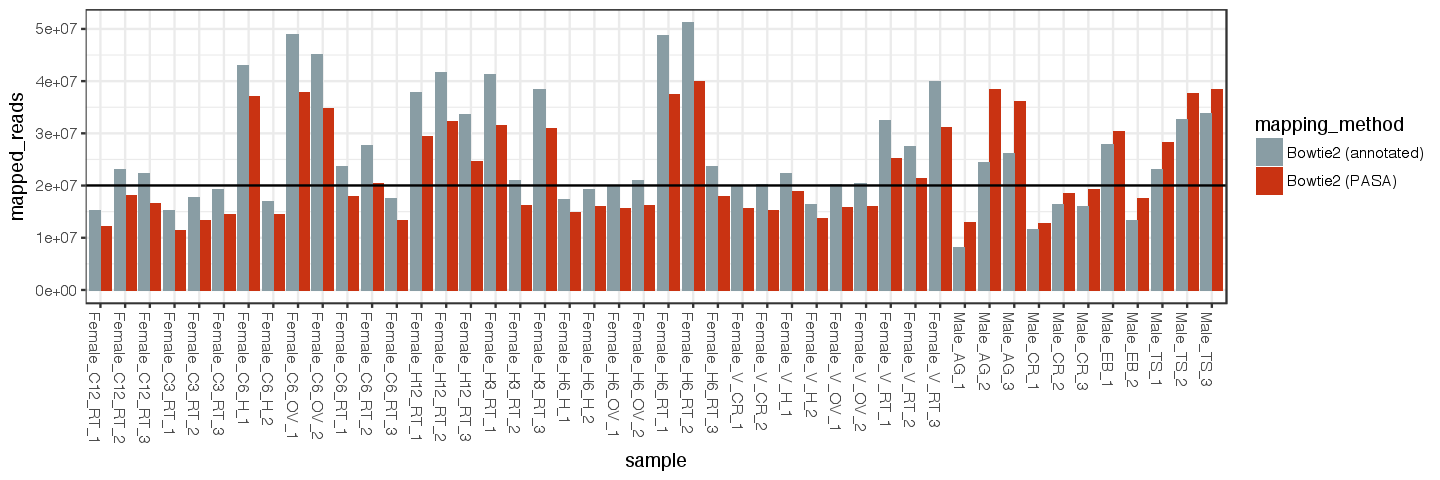

In [36]:
options(repr.plot.width = 12, repr.plot.height = 4)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(sample, mapped_reads, fill = mapping_method)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000) +
    scale_fill_manual(values = wes_palette("Royal1"))
# dev.off()

A couple of things to note here. Not surprisingly, the Trinity mapping has the highest number of mapped reads across samples, while the HISAT2 genome mapping has the lowest (this is reflected in the percentage of mapping as well; see the MultiQC output from the Snakemake pipeline). Another thing to note is that, for the paired-end male data, there is no difference in the number of mapped reads between the HISAT2 and Trinity bowtie2 alignments, suggesting the genome divergence issues are mitigated by paired-end data. 

Now we can look at the appropriate cutoffs for filtering using Brian Haas' method. To do this we count the genes acrtoss a range of minimum TPM values. The eXpress output we used generates a file that can be used to generate this matrix (see Trinity online guidelines). We'll load those two files for the genom- and Trinity-based analyses:

In [37]:
a.bt2_cbmt = read.table("Genome/annotated_eXpress/annotated.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)
pasa.bt2_cbmt = read.table("Trinity/pasa/eXpress/pasa.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)

First extract the "expressed genes" (in this case, between 10 and 100 TPM):

In [38]:
a.bt2_cbmt.sub = a.bt2_cbmt[a.bt2_cbmt[,1] > -100 & a.bt2_cbmt[,1] < -10,]
pasa.bt2_cbmt.sub = pasa.bt2_cbmt[pasa.bt2_cbmt[,1] > -100 & pasa.bt2_cbmt[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [39]:
a.bt2_cbmt.sub_fit = lm(a.bt2_cbmt.sub[,2] ~ a.bt2_cbmt.sub[,1])
print(a.bt2_cbmt.sub_fit)

pasa.bt2_cbmt.sub_fit = lm(pasa.bt2_cbmt.sub[,2] ~ pasa.bt2_cbmt.sub[,1])
print(pasa.bt2_cbmt.sub_fit)


Call:
lm(formula = a.bt2_cbmt.sub[, 2] ~ a.bt2_cbmt.sub[, 1])

Coefficients:
        (Intercept)  a.bt2_cbmt.sub[, 1]  
           11534.67                76.03  


Call:
lm(formula = pasa.bt2_cbmt.sub[, 2] ~ pasa.bt2_cbmt.sub[, 1])

Coefficients:
           (Intercept)  pasa.bt2_cbmt.sub[, 1]  
               18918.9                   149.8  



Combine both matrices before plotting:

Warning message:
"Removed 2674 rows containing missing values (geom_point)."

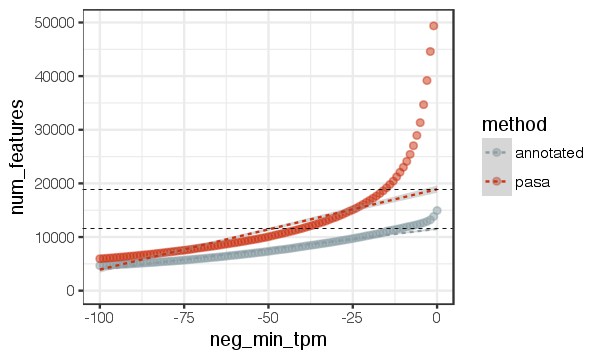

In [40]:
a.bt2_cbmt.sub$method = "annotated"
pasa.bt2_cbmt.sub$method = "pasa"
cbmtSub = rbind(a.bt2_cbmt.sub,pasa.bt2_cbmt.sub)

a.bt2_cbmt$method = "annotated"
pasa.bt2_cbmt$method = "pasa"
cbmtMatrix = rbind(a.bt2_cbmt,pasa.bt2_cbmt)

options(repr.plot.width = 5, repr.plot.height = 3)
# pdf("Figures/filtering_cutoff.pdf", width = 5, height = 3)
ggplot(cbmtMatrix, aes(neg_min_tpm, num_features, colour = method)) + 
    geom_point(alpha = 0.5) +  
    scale_x_continuous(limits=c(-100,0)) + 
    scale_y_continuous(limits=c(0,50000)) + 
    geom_smooth(data=cbmtSub, method = "lm",fullrange=TRUE, size = 0.5, linetype = "dashed") + 
    geom_hline(yintercept = 18918.9, linetype = "dashed", size = 0.2) + 
    geom_hline(yintercept = 11534.67, linetype = "dashed", size = 0.2) + 
#     ggtitle("Expressed genes", subtitle = "Decide cutoff of expressed genes") +
    scale_colour_manual(values = wes_palette("Royal1")) + 
    theme_bw()
# dev.off()

In the Trinity analysis, out of 105593 "genes", roughly 35000 should remain after filtering lowly expressed genes. Simmilarly, 13000 out of ~20000 genes should remain in the genome analysis. Filtering should be performed on subsetted matrices for each analysis later because the threshold for the whole matrix tends to be too high, but we'll see what it is here. First, obtain the counts per million "CPM" matrix:

In [41]:
cpm_bt2.fbgn <- cpm(counts_bt2.fbgn)
cpm_bt2.pasa <- cpm(counts_bt2.pasa)

For now, let's set the minimum CPM to 10, and generate a logical matrix for CPM > 10:

In [42]:
thresh_bt2.fbgn <- cpm_bt2.fbgn > 10
thresh_bt2.pasa <- cpm_bt2.pasa > 10

We would like to keep genes that have at least 2 "TRUE"s in each row of thresh:

In [43]:
keep_bt2.fbgn <- rowSums(thresh_bt2.fbgn) >= 2
keep_bt2.pasa<- rowSums(thresh_bt2.pasa) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [44]:
countsKeep_bt2.fbgn <- counts_bt2.fbgn[keep_bt2.fbgn,]
dim(countsKeep_bt2.fbgn)

countsKeep_bt2.pasa <- counts_bt2.pasa[keep_bt2.pasa,]
dim(countsKeep_bt2.pasa)

[1] 11301    46

[1] 19942    46

So a filter of 10 CPM brings the count matrix to the expected number of genes using Brian Haas' method. We would like to know what the CPM values correspond to in terms of raw counts. To do this, we'll plot CPM vs. counts for each sample. (look at the last 30)

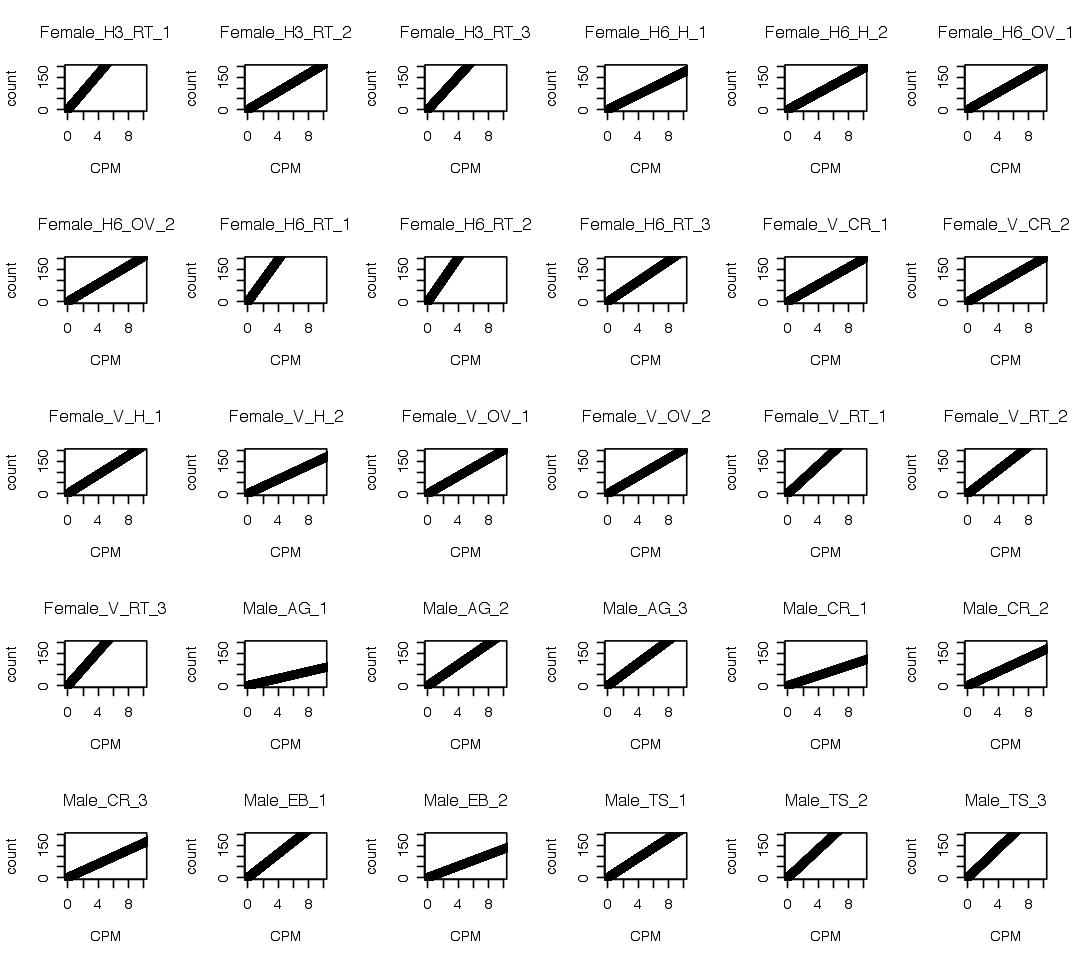

In [45]:
options(repr.plot.width = 9, repr.plot.height = 8)
par(mfrow=c(5,6))
for(i in seq(from=17, to=46, by=1)){
  plot(cpm_bt2.fbgn[,i],counts_bt2.fbgn[,i], xlim=c(0,10), ylim=c(0,200), xlab = "CPM", ylab = "count")
  title(colnames(cpm_bt2.fbgn)[i])
}

There's a range of correpondence between CPM values and raw counts. In general 10CPM seems to correspond to ~200 in raw counts.

## Differential Expression (annotated, genome-based analysis)

### Tissue-biased genes

In the first portion of the differential expression analysis we'll look at genes that show tissue-biased expression in females. We'll perform the analysis for the genome-based analysis and Trinity-based analysis separately.

First we'll subset the matrix to include virgin female tissue samples.

In [46]:
counts_bt2.fbgn.tissues = subset(counts_bt2.fbgn, select=grepl("Female_V", colnames(counts_bt2.fbgn)))

Now we can filter out low expression genes with a minimum 5 cpm cutoff (NOTE: Setting the threshold column number to 3 dramatically changes the number of tissue biased genes in this section).

In [47]:
cpm_bt2.fbgn.tissues <- cpm(counts_bt2.fbgn.tissues)
thresh_v.bt2.fbgn <- cpm_bt2.fbgn.tissues > 5
## look at number of columns with above requirements
table(rowSums(thresh_v.bt2.fbgn))

countsKeep_v.bt2.fbgn <- rowSums(thresh_v.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.tissues <- counts_bt2.fbgn.tissues[countsKeep_v.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.tissues)


## Clean-up
rm(cpm_bt2.fbgn.tissues, countsKeep_v.bt2.fbgn, thresh_v.bt2.fbgn)


   0    1    2    3    4    5    6    7    8    9 
4963  224 1465  642  492  324  246  836  516 5236 

[1] 9757    9

We'll also subset the samplesData object to only include the virgin tissue and male samples:

In [48]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")

We can now define groups for differential expression:

In [49]:
groups.v = factor(sampleInfo.v$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.v$Replicate

Now we'll create the DGE object and fit the general linear model:

In [50]:
dgeList.v <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateCommonDisp(dgeList.v)
dgeList.v <- estimateTagwiseDisp(dgeList.v)
dgeList.v_fit <- glmFit(dgeList.v, design.v)

We can add annotation information to the fit object, and put it in the genes slot:

In [51]:
Annots = merge(merge(melOrthsAll, trinotate_annotated, all=TRUE), dv1.06_features, all=TRUE)
annot.sum = unique(subset(Annots, select=c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description")))
annot.sum = aggregate(SwissProt_BlastX_Description ~ FBgn_ID + gene_name, data = annot.sum, toString)

now create the annotation object:

In [52]:
# Extract annotation for genes in the fit object
ann.v = subset(Annots, FBgn_ID %in% rownames(dgeList.v_fit))
# convert factors to characters
ann.v = data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.v = ann.v[match(rownames(dgeList.v_fit), ann.v$FBgn_ID),]
# convert factors to characters, again
ann.v <- data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.v) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.v$GeneID==rownames(dgeList.v_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.v_fit$genes = ann.v


TRUE 
9757 

A quick look at the dispersion stats:

In [53]:
summary(dgeList.v$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01993 0.02820 0.03700 0.05979 0.05430 2.15200 

We can plot the biological coefficient of variation to examine variability within each sample. It would also be useful to generatea voom object as an aside to check compare to the edgeR analyses (from this objectm we can look at the mean-variance trend). Also, let's generate a QQ-plot.

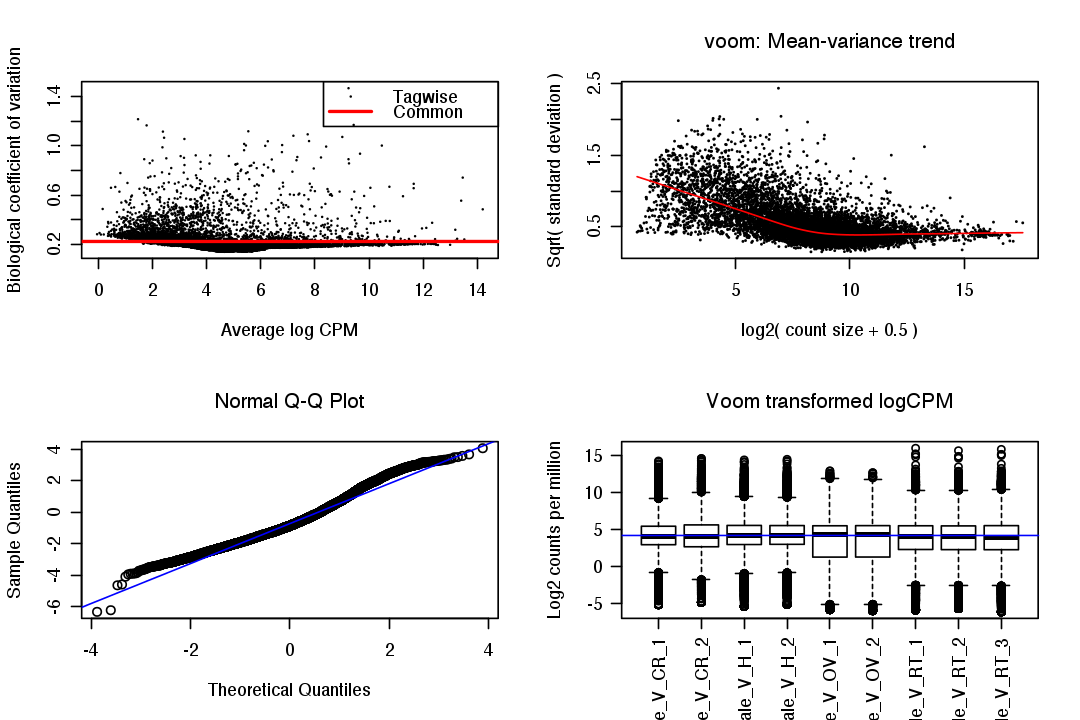

In [54]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.v)
# mean-variance trend
virgin.voom = voom(dgeList.v, design.v, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.v_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

In [55]:
glMDSPlot(dgeList.v, groups = dgeList.v$samples$group, labels = sampleInfo.v$Replicate)

Replicates are grouping correctly. Another way to look at grouping is a heatmap of sample correlations:

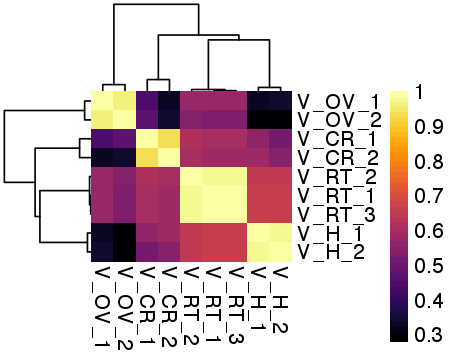

In [56]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.tissues+1)
colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 3.75, repr.plot.height = 3)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [57]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)
cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)
# cont.v.carcass <- makeContrasts(V_CR.vs.V_H=carcass-head,
#                              V_CR.vs.V_OV=carcass-ovaries,
#                              V_CR.vs.V_RT=carcass-repTract,
#                              levels=design.v)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

##### Reprotductive tract:

In [58]:
lrt.v.repTract <- glmLRT(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
repTract.list<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 1 & logFC.V_RT.vs.V_HD > 1 & logFC.V_RT.vs.V_OV > 1 & FDR<0.01)$GeneID
repTract.list.4fold<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.01)$GeneID
repTract.list.10fold<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 3.32 & logFC.V_RT.vs.V_HD > 3.32 & logFC.V_RT.vs.V_OV > 3.32 & FDR<0.01)$GeneID

paste(length(repTract.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(repTract.list.4fold), " at a >4-fold cutoff, and ", length(repTract.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "667 genes show RT-biased expression at a >2-fold cutoff, 283 at a >4-fold cutoff, and 119 at a >10-fold cutoff."

##### Ovaries:

In [59]:
lrt.v.ovaries <- glmLRT(dgeList.v_fit, contrast = cont.v.ovaries)
lrt.v.ovaries.tTags <- topTags(lrt.v.ovaries, n = NULL)
lrt.v.ovaries.tTags.table <- lrt.v.ovaries.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
ovaries.list<-subset(lrt.v.ovaries.tTags.table, logFC.V_OV.vs.V_CR > 1 & logFC.V_OV.vs.V_HD > 1 & logFC.V_OV.vs.V_RT > 1 & FDR<0.01)$GeneID
ovaries.list.4fold<-subset(lrt.v.ovaries.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_HD > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.01)$GeneID
ovaries.list.10fold<-subset(lrt.v.ovaries.tTags.table, logFC.V_OV.vs.V_CR > 3.32 & logFC.V_OV.vs.V_HD > 3.32 & logFC.V_OV.vs.V_RT > 3.32 & FDR<0.01)$GeneID

paste(length(ovaries.list), " genes show OV-biased expression at a >2-fold cutoff, ", length(ovaries.list.4fold), " at a >4-fold cutoff, and ", length(ovaries.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "2118 genes show OV-biased expression at a >2-fold cutoff, 776 at a >4-fold cutoff, and 121 at a >10-fold cutoff."

##### Head:

In [60]:
lrt.v.head <- glmLRT(dgeList.v_fit, contrast = cont.v.head)
lrt.v.head.tTags <- topTags(lrt.v.head, n = NULL)
lrt.v.head.tTags.table <- lrt.v.head.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
head.list<-subset(lrt.v.head.tTags.table, logFC.V_H.vs.V_CR > 1 & logFC.V_H.vs.V_OV > 1 & logFC.V_H.vs.V_RT > 1 & FDR<0.01)$GeneID
head.list.4fold<-subset(lrt.v.head.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.01)$GeneID
head.list.10fold<-subset(lrt.v.head.tTags.table, logFC.V_H.vs.V_CR > 3.32 & logFC.V_H.vs.V_OV > 3.32 & logFC.V_H.vs.V_RT > 3.32 & FDR<0.01)$GeneID


paste(length(head.list), " genes show H-biased expression at a >2-fold cutoff, ", length(head.list.4fold), " at a >4-fold cutoff, and ", length(head.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "1021 genes show H-biased expression at a >2-fold cutoff, 740 at a >4-fold cutoff, and 481 at a >10-fold cutoff."

##### Carcass (this isn't terribly important, especially since one of the carcass replicates may have gotten contaminated with ovary material (see heatmap of replicates below). But we'll do it anyway ):

In [61]:
# lrt.v.carcass <- glmLRT(dgeList.v_fit, contrast = cont.v.carcass)
# lrt.v.carcass.tTags <- topTags(lrt.v.carcass, n = NULL)
# lrt.v.carcass.tTags.table <- lrt.v.carcass.tTags$table
# carcass.list<-subset(lrt.v.carcass.tTags.table, logFC.V_CR.vs.V_H > 1 & logFC.V_CR.vs.V_OV > 1 & logFC.V_CR.vs.V_RT > 1 & FDR<0.01)$GeneID
# paste(length(carcass.list), " show carcass-biased expression", sep = "")

We can generate tissue-biased factor tables to annotate heatmaps of the tissue-biased genes, and can also be used for GO analysis later:

In [62]:
RT_factors = as.data.frame(repTract.list.4fold)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = repTract.list.4fold
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(ovaries.list.4fold)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = ovaries.list.4fold
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(head.list.4fold)
H_factors$V1 = "H-biased"
rownames(H_factors) = head.list.4fold
H_factors = subset(H_factors, select = "V1")

virgin.factor.labeling = rbind(RT_factors, 
                               OV_factors, 
#                                CR_factors, 
                               H_factors)
colnames(virgin.factor.labeling) = c('tissue_bias')
virgin.factor_list = unique(virgin.factor.labeling[,1])

For a heatmap, we'll subset from the mean TPM matrix produced in the introduction:

In [63]:
meanTPM_v_bt2.fbgn = subset(tpmMatrix_bt2.fbgn, rownames(tpm_bt2.fbgn) %in% rownames(virgin.factor.labeling))
meanTPM_v_bt2.fbgn = subset(meanTPM_v_bt2.fbgn, select=grepl("Female_V", colnames(meanTPM_v_bt2.fbgn)))
colnames(meanTPM_v_bt2.fbgn) = gsub("Female_V_", "", colnames(meanTPM_v_bt2.fbgn))

Some more bells and whistles to generate the heatmap (for now with heatmap.3, fix this later and use the heatmap3 package):

In [64]:
data = meanTPM_v_bt2.fbgn
gene_factors = unique(virgin.factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#271fc5','black','#9de100')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(virgin.factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#00b468",
"#8781ff",
# "#534300",
"#aea800")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

For a heatmap using "pheatmap", here's how to rotate column labels:

In [65]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

Set the colours for the side bar like so:

In [66]:
mat_colors <- list(tissue_bias = c("#c75f65",
"#949b48",
"#9475c5"))
names(mat_colors$tissue_bias) <- unique(virgin.factor_list)

Can set the scale breaks like this:

In [67]:
# mat_breaks <- seq(min(heatmap_data), max(heatmap_data), length.out = 10)

Or this is better:

In [68]:
# quantile_breaks <- function(xs, n = 10) {
#   breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
#   breaks[!duplicated(breaks)]
# }

# mat_breaks <- quantile_breaks(mat, n = 101)

Now plot it:

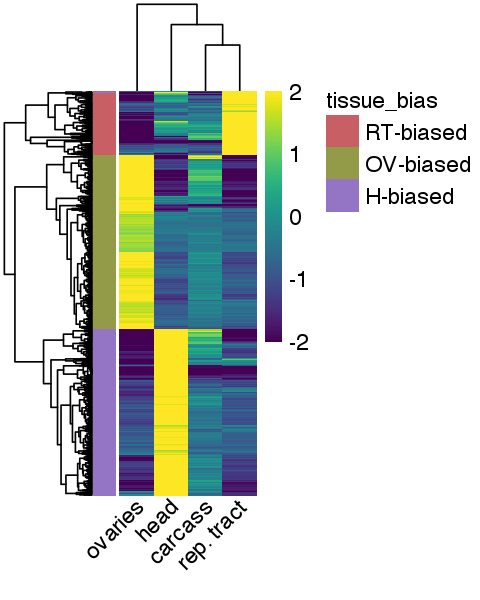

In [69]:
options(repr.plot.width = 4, repr.plot.height = 5)

fig2A = pheatmap(
  mat               = heatmap_data,
  color             = viridis(100),
#   breaks            = mat_breaks,
  border_color      = NA,
  labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
  annotation_row    = virgin.factor.labeling,
  annotation_colors = mat_colors,
  drop_levels       = TRUE,
  annotation_names_row = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/tissue-biased_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 13    
)

#### Gene Ontology

Process the gene length information and GO annotation files for GOseq:

In [71]:
GO_info_listed = apply(GOinfo_annotated, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GOinfo_annotated)
features_with_GO = rownames(GOinfo_annotated)
lengths_features_with_GO = a.gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

We'll process some of this and come up with the null expectation for GO terms, then plot the proportion of tissue-biased genes as a function of those biased in bins of 200:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

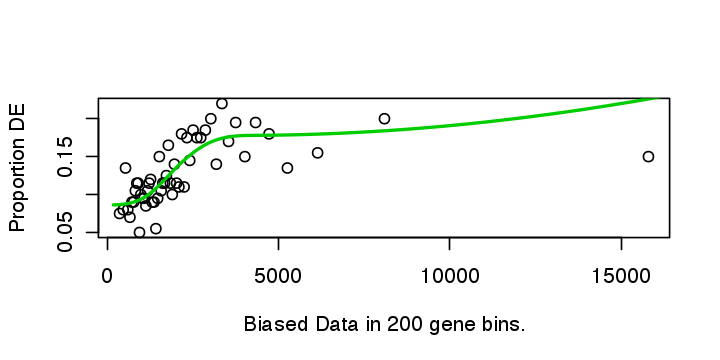

In [72]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

That looks fine. Now we'll process each tissue biased category of genes in a for-loop to identify enriched GO terms and their FDR values:

In [73]:
GO_enriched_list = list()

for (feature_cat in virgin.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling)[virgin.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: RT-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: OV-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: H-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Output the significant GO terms to the Results folder:

In [74]:
write.table(subset(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-female_tissue-biased_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

This above list of GO terms is fairly exhaustive. Will need to trim it down to ancestral terms for the sections below. To do this we can use the GOtrim JAVA program, then reload the table indicating soft- or hard-trimmed terms:

In [75]:
# RT_GO_sub = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "RT-biased")
# RT_GO_sub = subset(RT_GO_sub, select = c("category", "numDEInCat", "numInCat"))
# write.table(RT_GO_sub, "Results/GO_analyses/GO_results-female_RT-biased_genes_aBT2.csv", quote = F, sep = ",", row.names = F)

Three trimmed versions of the RT-biased GO terms were generated, with three diiffferent values for the soft trimming parameter: 0, 0.4, and 1. Let's load one of those here:

In [76]:
# RT_GO_sub_GOtrimmed_1.00 = read.csv("Results/GO_analyses/GO_results-female_RT-biased_genes_aBT2_GOtrimmed_1.00.csv")
# RT_untrimmed_GOterms = subset(RT_GO_sub_GOtrimmed_1.00, Hard.Trimmed. != "YES" & Soft.Trimmed. != "YES")$GO.Accession.No.

Now let's subset the RT GO table to only include untrimmed terms:

In [77]:
# RT_GO_sub_GOtrimmed = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "RT-biased" & category %in% RT_untrimmed_GOterms)

Let's write this out to a file for closer scrutiny:

In [78]:
# write.table(RT_GO_sub_GOtrimmed, "Results/GO_analyses/GO_results-female_RT-biased_genes_aBT2_GOtrimmed_1.00_complete.txt", quote = F, sep = "\t", row.names = F)

Let's look at some of the enriched terms in the reproductive tract. First, Molecular function:

In [79]:
# subset(RT_GO_sub_GOtrimmed, ontology == "MF" & over_represented_FDR < 0.01)[,c("category","term","numDEInCat")]

In [80]:
subset(GO_enrichment_data, ontology == "MF" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category,term,numDEInCat
GO:0042302,structural constituent of cuticle,10
GO:0022857,transmembrane transporter activity,33
GO:0022891,substrate-specific transmembrane transporter activity,29
GO:0004252,serine-type endopeptidase activity,13
GO:0005215,transporter activity,35


Some interesting terms here include "transporter activity", "serine-type endopeptidase activity", and "structural constituent of cuticle". We'll output individual gene expression plots for each of those categories:

In [81]:
RT_biased_transport_genes = extract_GO_genes(go_term = "GO:0005215", gene_set = repTract.list)
RT_biased_transport_genes_boxPlots = suppressMessages(lapply(RT_biased_transport_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT-biased_transport_proteins.pdf", marrangeGrob(grobs = RT_biased_transport_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


In [82]:
RT_biased_endopeptidase_genes = extract_GO_genes(go_term = "GO:0004252", gene_set = repTract.list)
RT_biased_endopeptidase_genes_boxPlots = suppressMessages(lapply(RT_biased_endopeptidase_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT-biased_endopeptidase_proteins.pdf", marrangeGrob(grobs = RT_biased_endopeptidase_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


In [83]:
RT_biased_cuticle_genes = extract_GO_genes(go_term = "GO:0042302", gene_set = repTract.list)
RT_biased_cuticle_genes_boxPlots = suppressMessages(lapply(RT_biased_cuticle_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT-biased_cuticle_proteins.pdf", marrangeGrob(grobs = RT_biased_cuticle_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


Now let's look at the genes in the Biological Process categories:

In [84]:
subset(GO_enrichment_data, ontology == "BP" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category,term,numDEInCat
GO:0055085,transmembrane transport,31
GO:0014706,striated muscle tissue development,7
GO:0048513,animal organ development,32
GO:0060537,muscle tissue development,7
GO:0007617,mating behavior,6
GO:0009888,tissue development,20


Potentially lots of overlap between genes in this ontology class and the MF ontology class, but the "mating behaviour" category is interesting. We'll make a plot object for those:.

In [85]:
RT_biased_mating_behavior_genes = extract_GO_genes(go_term = "GO:0007617", gene_set = repTract.list)
RT_biased_mating_behavior_genes_boxPlots = suppressMessages(lapply(RT_biased_mating_behavior_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT-biased_mating_behavior_proteins.pdf", marrangeGrob(grobs = RT_biased_mating_behavior_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


... and the Cellular Component category

In [86]:
subset(GO_enrichment_data, ontology == "CC" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category,term,numDEInCat
GO:0005615,extracellular space,27
GO:0005576,extracellular region,35
GO:0044459,plasma membrane part,40
GO:0044449,contractile fiber part,10
GO:0030018,Z disc,8
GO:0016324,apical plasma membrane,11
GO:0044421,extracellular region part,39
GO:0030017,sarcomere,5
GO:0031224,intrinsic component of membrane,73
GO:0005859,muscle myosin complex,4


Let's plot the _Ka/Ks_ values of RT-biased genes along chromosomes. First we'll make a table containing all the relevant data:

In [87]:
AN_KaKs_data = (filter(KaKs.data, COMPARISON == "D.amr_vs_D.nov" & Ks > 0.0003))
AN_KaKs_data = merge(AN_KaKs_data, FBgn_to_FBtr, by.x = "FBtr_ID", by.y = "FBtr_ID", all.x = TRUE)
AN_KaKs_data = merge(AN_KaKs_data, dv1.06_features, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
AN_KaKs_data = merge(AN_KaKs_data, annot.sum, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
AN_KaKs_data$status = ifelse(AN_KaKs_data$FBgn_ID %in% repTract.list.4fold, "RT-biased", ifelse(AN_KaKs_data$FBgn_ID %in% AG_biased, "AG-biased", ifelse(AN_KaKs_data$FBgn_ID %in% SFPs, "SFPs", "all")))

Now make a plot:

In [88]:
AN_KaKs_data$KaKs = AN_KaKs_data$`Ka/Ks`

In [89]:
KaKs.test <- as.data.frame(compare_means(
 KaKs ~ status, data = AN_KaKs_data,
 method = "wilcox.test"
))
# (KaKs.test <- filter(KaKs.test, group1 == "RT-biased"))
KaKs.test

.y.,group1,group2,p,p.adj,p.format,p.signif,method
KaKs,all,RT-biased,8.112527e-01,8.1e-01,0.811,ns,Wilcoxon
KaKs,all,SFPs,4.418815e-14,2.7e-13,4.4e-14,****,Wilcoxon
KaKs,all,AG-biased,6.575736e-08,2.6e-07,6.6e-08,****,Wilcoxon
KaKs,RT-biased,SFPs,9.493739e-14,4.7e-13,9.5e-14,****,Wilcoxon
KaKs,RT-biased,AG-biased,4.792568e-07,1.4e-06,4.8e-07,****,Wilcoxon
KaKs,SFPs,AG-biased,2.610524e-02,5.2e-02,0.026,*,Wilcoxon


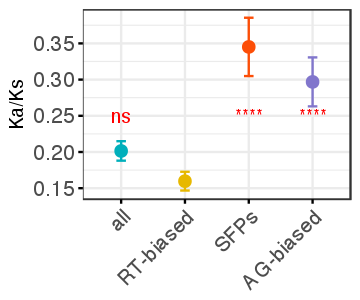

In [90]:
KaKs_comparisons <- list( c("RT-biased", "all"), c("RT-biased", "SFPs"), c("RT-biased", "AG-biased") )

KaKs_y_title <- expression(paste(italic("Ka/Ks")))

options(repr.plot.width = 3, repr.plot.height = 2.5)
# pdf("Figures/mean_KaKs.pdf", width = 3, height = 2.5)
(fig2D = ggerrorplot(AN_KaKs_data, 
            x = "status", 
            y = "Ka/Ks", 
            color = "status",
            add = "mean", 
#             desc_stat = "mean_ci",
            error.plot = "errorbar",
            ggtheme = theme_bw(),
            palette = c("#00AFBB", "#E7B800", "#FC4E07", "#8176cc")
           ) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12), 
              legend.position = "none", 
              axis.title.x = element_blank(), 
              axis.text.y = element_text(size = 12)) +
#               stat_pvalue_manual(KaKs.test, label = "p.adj") +
        stat_compare_means(ref.group = "RT-biased", 
                           method = "wilcox.test", 
                           label.y = 0.25, 
                           aes(label = ..p.signif..), color = "red"
                          )  +
#         scale_y_continuous(values = c(0.15,0.42)) +
        labs(y = KaKs_y_title))
        
# dev.off()

Let's plot omega across the genome:

In [91]:
newData = merge(paml2.data, FBgn_to_FBtr, by.x = "FBtr_ID", by.y = "FBtr_ID", all.x = TRUE)
newData = merge(newData, dv1.06_features, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
newData = merge(newData, annot.sum, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)

Warning message:
"Removed 2 rows containing missing values (geom_point)."

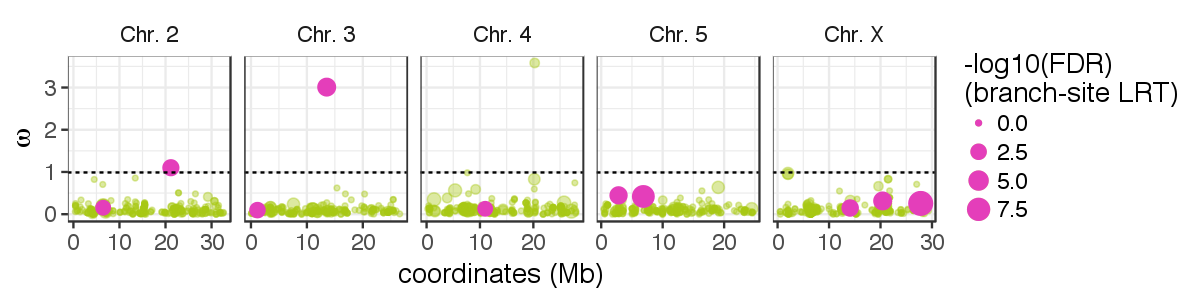

In [92]:
options(repr.plot.width = 10, repr.plot.height = 2.5)
omega_y_title <- expression(paste(italic(omega)))
newData$chromosome = gsub("Chr_", "Chr. ", newData$chromosome)

newData$sig = ifelse(newData$Dvir_FDR < 0.01, "yes", "no")
# pdf("Figures/KaKs_RT-biased_chromosomes.pdf", width = 10, height = 2.5)
(fig2E = ggplot(filter(newData, grepl("Chr", chromosome) & chromosome != "Chr. 6" & FBgn_ID %in% repTract.list & sig == "no"), aes(min, omega, size = -log10(Dvir_FDR))) + 
    geom_point(alpha = 0.4, colour = "#a7c814") + 
    geom_point(data =filter(newData, grepl("Chr", chromosome) & chromosome != "Chr. 6" & FBgn_ID %in% repTract.list & sig == "yes"), colour = "#e43eba") +
    facet_grid(.~chromosome, scales = "free_x") + 
    geom_hline(yintercept = 1, linetype = "dashed") +
    scale_x_continuous(breaks=seq(from=0, to=30e6, by = 10e6), labels=as.character(seq(0,30,10))) +
#     geom_text_repel(data = filter(newData, grepl("Chr", chromosome) & chromosome != "Chr. 6" & FBgn_ID %in% repTract.list & Dvir_FDR < 0.01), aes(label = gene_name.x), size = 4, fontface = "bold.italic", force = 1, colour = "black") +
    labs(x = "coordinates (Mb)", y = omega_y_title) +
    guides(size=guide_legend(title="-log10(FDR)\n(branch-site LRT)"))+
    theme(strip.background =  element_rect(colour = "white", fill = "white")))
# dev.off()

Now let's plot the percent identity for cDNA and protein of these gene categories. First make the summarySE data

In [93]:
KaKs.data$status = ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% repTract.list.4fold)$FBtr_ID, "RT-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% AG_biased)$FBtr_ID, "AG-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% TS_biased)$FBtr_ID, "testes-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% EB_biased)$FBtr_ID, "EB-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% ovaries.list.4fold)$FBtr_ID, "OV-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% SFPs)$FBtr_ID, "SFPs", "all"))))))

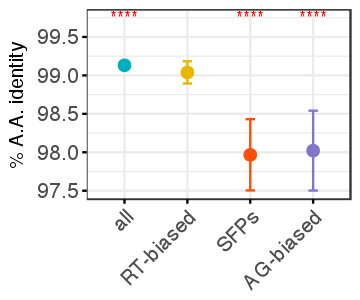

In [94]:
options(repr.plot.width = 3, repr.plot.height = 2.5)

# pdf("Figures/percent_identity.pdf", width = 3, height = 2.5)
(fig2C = ggerrorplot(filter(KaKs.data, COMPARISON == "D.amr_vs_D.nov" & (status == "all" | status == "AG-biased" | status == "RT-biased" | status == "SFPs")), 
            x = "status", 
            y = "PROT_PERCENTID", 
            color = "status",
            add = "mean", 
            error.plot = "errorbar",
            desc_stat = "mean_ci",
            ggtheme = theme_bw(),
            palette = c("#00AFBB", "#E7B800", "#FC4E07", "#8176cc")
           ) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12), 
              legend.position = "none", 
              axis.title.x = element_blank(), 
              axis.text.y = element_text(size = 12)) +
#               stat_pvalue_manual(KaKs.test, label = "p.adj") +
        stat_compare_means(ref.group = "RT-biased", 
                           method = "wilcox.test", 
                           label.y = 99.75, 
                           aes(label = ..p.signif..), color = "red"
                          )  +
#         scale_y_continuous(values = c(0.15,0.42)) +
        labs(x = "Gene class", y = "% A.A. identity"))
        
# dev.off()

Finally, let's look at the chromosomal distribution of these gene categories:

In [95]:
TotalGeneNumber = as.data.frame(table(factor(subset(dv1.06_features, grepl("Chr", chromosome))$chromosome)))
colnames(TotalGeneNumber) = c("chromosome", "All genes")
total_genes = nrow(dv1.06_features)
TotalGeneNumber$proportion = (TotalGeneNumber$`All genes`/total_genes)

Output tissue-biased data:

In [96]:
## SFPs
genomeNumber.SFPs = length(SFPs)
chromNumber.SFPs=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% SFPs & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.SFPs) = c("chromosome", "Observed_biased_genes")
chromNumber.SFPs$sex = "male"
chromNumber.SFPs = merge(TotalGeneNumber, chromNumber.SFPs)
chromNumber.SFPs$`Expected genes` = genomeNumber.SFPs*chromNumber.SFPs$proportion
chromNumber.SFPs$`obs.exp` = chromNumber.SFPs$Observed_biased_genes/chromNumber.SFPs$`Expected genes`
chromNumber.SFPs$`Gene category` = "SFPs"

## AG_biased
genomeNumber.AG_biased = length(AG_biased)
chromNumber.AG_biased=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% AG_biased & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.AG_biased) = c("chromosome", "Observed_biased_genes")
chromNumber.AG_biased$sex = "male"
chromNumber.AG_biased = merge(TotalGeneNumber, chromNumber.AG_biased)
chromNumber.AG_biased$`Expected genes` = genomeNumber.AG_biased*chromNumber.AG_biased$proportion
chromNumber.AG_biased$`obs.exp` = chromNumber.AG_biased$Observed_biased_genes/chromNumber.AG_biased$`Expected genes`
chromNumber.AG_biased$`Gene category` = "AG_biased"

## repTract.list.4fold
genomeNumber.repTract = length(repTract.list.4fold)
chromNumber.repTract=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% repTract.list.4fold & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.repTract) = c("chromosome", "Observed_biased_genes")
chromNumber.repTract$sex = "female"
chromNumber.repTract = merge(TotalGeneNumber, chromNumber.repTract)
chromNumber.repTract$`Expected genes` = genomeNumber.repTract*chromNumber.repTract$proportion
chromNumber.repTract$`obs.exp` = chromNumber.repTract$Observed_biased_genes/chromNumber.repTract$`Expected genes`
chromNumber.repTract$`Gene category` = "RT_biased"

## ovaries.list
genomeNumber.ovaries = length(ovaries.list.4fold)
chromNumber.ovaries=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% ovaries.list.4fold & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.ovaries) = c("chromosome", "Observed_biased_genes")
chromNumber.ovaries$sex = "female"
chromNumber.ovaries = merge(TotalGeneNumber, chromNumber.ovaries)
chromNumber.ovaries$`Expected genes` = genomeNumber.ovaries*chromNumber.ovaries$proportion
chromNumber.ovaries$`obs.exp` = chromNumber.ovaries$Observed_biased_genes/chromNumber.ovaries$`Expected genes`
chromNumber.ovaries$`Gene category` = "OV_biased"

Combine the elements above and perform a Chi-square test:

In [97]:
tissue_biased.numbers = rbind(chromNumber.SFPs, chromNumber.AG_biased, chromNumber.repTract, chromNumber.ovaries)
tissue_biased.numbers$`Gene category` = factor(tissue_biased.numbers$`Gene category`, levels = c("SFPs", "AG_biased","RT_biased", "OV_biased"))
tissue_biased.numbers$Chr = gsub("Chr_", "", tissue_biased.numbers$chromosome)
tissue_biased.numbers$Chr = factor(tissue_biased.numbers$Chr, levels = c("X", "2","3", "4", "5"))

tissue_biased.numbers$ChiSq = ((tissue_biased.numbers$Observed_biased_genes-tissue_biased.numbers$`Expected genes`)^2)/tissue_biased.numbers$`Expected genes`

tissue_biased.numbers$pval = 1-(pchisq(tissue_biased.numbers$ChiSq, df = 1))
tissue_biased.numbers$FDR = tissue_biased.numbers$pval*nrow(tissue_biased.numbers)

tissue_biased.numbers$sigLabel = NULL
tissue_biased.numbers$sigLabel = ifelse(tissue_biased.numbers$pval < 0.05 & tissue_biased.numbers$pval > 0.01, "*", ifelse(tissue_biased.numbers$pval < 0.01 & tissue_biased.numbers$pval > 0.001, "**", ifelse(tissue_biased.numbers$pval < 0.001, "***", "")))

Now plot it:

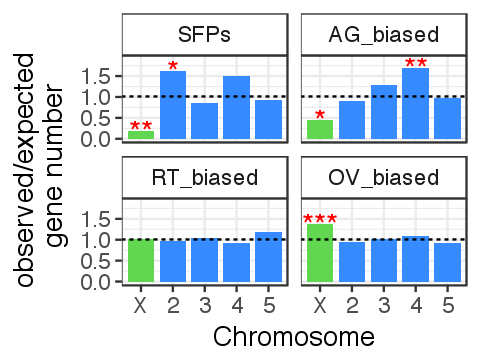

In [98]:
options(repr.plot.width = 4, repr.plot.height = 3)
# pdf("Figures/chromosome_distribution.pdf", width = 4, height = 3)
(fig2B = ggplot(filter(tissue_biased.numbers, chromosome != "Chr_6"), aes(Chr, obs.exp, fill = Chr)) +
    facet_wrap(~`Gene category`) +
    geom_bar(position=position_dodge(), stat="identity", width = 0.8) +
    geom_hline(yintercept = 1, linetype = "dashed") +
    scale_fill_manual(values = c("#61d650", "#358bff","#358bff", "#358bff", "#358bff")) +
    labs(x = "Chromosome", y = "observed/expected\n gene number") +
    geom_text(aes(label = sigLabel), size = 6, colour = "red", position=position_dodge(width = 0.8)) +
    theme(legend.position = "none", strip.background = element_rect(fill = "white")) +
    scale_y_continuous(limits=c(0,1.9)))
# dev.off()

Let's try to combine all of these into one figure:

In [99]:
# fig2bcd = plot_grid(fig2B, fig2C, fig2D, labels = c("B", "C", "D"), scale = c(0.9, 0.9, 0.9), ncol = 3)
# options(repr.plot.width = 10, repr.plot.height = 6)
# (fig2bcde = plot_grid(fig2bcd, fig2E, labels = c("", "E"), scale = c(1, 0.9), ncol = 1))
# (fig2abcde = plot_grid(grid.arrange(grobs = list(fig2A[[4]])), fig2bcde, labels = c("A", ""), scale = c(0.9, 1), ncol = 2, rel_widths = 0.3, 1))

## Reproductive tract post-mating contrasts:

POST-HOC... after checking the grouping of replicates below, there are a couple of rogue replicates that we can remove for the remainder of this part of the analysis (these seem to have had an ovary in them that skewes expression in ovary biased genes):

In [100]:
## Define good replicates
RT_GoodReps = as.character(subset(sampleInfo, Replicate != "Female_H3_RT_1" & Replicate != "Female_H6_RT_1" & Tissue == "repTract")$Replicate)
RT_GoodReps = gsub("Female_", "", RT_GoodReps)

Create RT-specific count matrix 

In [101]:
counts_bt2.fbgn.RT = subset(counts_bt2.fbgn, select=grepl("RT", colnames(counts_bt2.fbgn)))

#######
## use this subset command if we want to remove the ovary-biased genes
# counts_bt2.fbgn.RT = subset(subset(counts_bt2.fbgn, rownames(counts_bt2.fbgn) %!in% ovaries.list.4fold), select=grepl("RT", colnames(counts_bt2.fbgn)))
#######

colnames(counts_bt2.fbgn.RT) = gsub("Female_", "", colnames(counts_bt2.fbgn.RT))
# counts_bt2.fbgn.RT = subset(counts_bt2.fbgn.RT, select=RT_GoodReps)

Now let's filter low expression genes within a minimum cpm of 2:

In [102]:
cpm_bt2.fbgn.RT <- cpm(counts_bt2.fbgn.RT)
thresh_RT.bt2.fbgn <- cpm_bt2.fbgn.RT > 5

countsKeep_RT.bt2.fbgn <- rowSums(thresh_RT.bt2.fbgn) >= 3
countsFiltered_bt2.fbgn.RT <- counts_bt2.fbgn.RT[countsKeep_RT.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.RT)

## Clean-up
rm(cpm_bt2.fbgn.RT, countsKeep_RT.bt2.fbgn, thresh_RT.bt2.fbgn)

[1] 7528   21

We'll also subset the samplesInfo object to only include the RT samples:

In [103]:
sampleInfo.pm = subset(sampleInfo, Tissue == "repTract")
# remove rogue replicates:
# sampleInfo.pm = subset(sampleInfo.pm, Replicate != "Female_H3_RT_1" & Replicate != "Female_H6_RT_1")
sampleInfo.pm$SampleName = gsub("Female_", "", sampleInfo.pm$SampleName)
sampleInfo.pm$Replicate = gsub("Female_", "", sampleInfo.pm$Replicate)

### Comparing con- and heterospeicific postmating time points to each other and to the virgin RT sample:

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors. This design matrix will test differences between each postmating time-point and the virgin sample:

In [104]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.pm$Status, sampleInfo.pm$Time, sep="."))
sampleInfo.pmv <- cbind(sampleInfo.pm, Group=Status.time)
sampleInfo.pmv$Group <- relevel(sampleInfo.pmv$Group, ref = "virgin.virgin")

groups.pmv <- factor(sampleInfo.pmv$Group)
design.pmv <- model.matrix(~groups.pmv)
colnames(design.pmv) <- levels(groups.pmv)
rownames(design.pmv) <- sampleInfo.pmv$Replicate

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [105]:
groups.pmb <- factor(sampleInfo.pm$SampleName)
design.pmb <- model.matrix(~ 0 + groups.pmb)
colnames(design.pmb) <- levels(groups.pmb)
rownames(design.pmb) <- sampleInfo.pm$Replicate

Create edgeR DE object and run glmFit

In [106]:
dgeList.pmv <- DGEList(counts = countsFiltered_bt2.fbgn.RT, group = groups.pmv)
dgeList.pmv <- calcNormFactors(dgeList.pmv)
dgeList.pmv <- estimateCommonDisp(dgeList.pmv)
dgeList.pmv <- estimateTagwiseDisp(dgeList.pmv)
dgeList.pmv_fit <- glmFit(dgeList.pmv, design.pmv)

In [107]:
dgeList.pmb <- DGEList(counts = countsFiltered_bt2.fbgn.RT, group = groups.pmb)
dgeList.pmb <- calcNormFactors(dgeList.pmb)
dgeList.pmb <- estimateCommonDisp(dgeList.pmb)
dgeList.pmb <- estimateTagwiseDisp(dgeList.pmb)
dgeList.pmb_fit <- glmFit(dgeList.pmb, design.pmb)

Let's add the annotation information to this fit object:

In [108]:
# Extract annotation for genes in the fit object
ann.pmv = subset(Annots, FBgn_ID %in% rownames(dgeList.pmv_fit))
ann.pmv = subset(ann.pmv, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pmv = data.frame(lapply(ann.pmv, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pmv = ann.pmv[match(rownames(dgeList.pmv_fit), ann.pmv$FBgn_ID),]
# convert factors to characters, again
ann.pmv <- data.frame(lapply(ann.pmv, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pmv) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pmv$GeneID==rownames(dgeList.pmv_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pmv_fit$genes = ann.pmv


TRUE 
7528 

In [109]:
# Extract annotation for genes in the fit object
ann.pmb = subset(Annots, FBgn_ID %in% rownames(dgeList.pmb_fit))
ann.pmb = subset(ann.pmb, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pmb = data.frame(lapply(ann.pmb, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pmb = ann.pmb[match(rownames(dgeList.pmb_fit), ann.pmb$FBgn_ID),]
# convert factors to characters, again
ann.pmb <- data.frame(lapply(ann.pmb, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pmb) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pmb$GeneID==rownames(dgeList.pmb_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pmb_fit$genes = ann.pmb


TRUE 
7528 

Also, check the tagwise dispersion summary:

In [110]:
summary(dgeList.pmv$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005103 0.008586 0.011390 0.022630 0.017340 1.237000 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

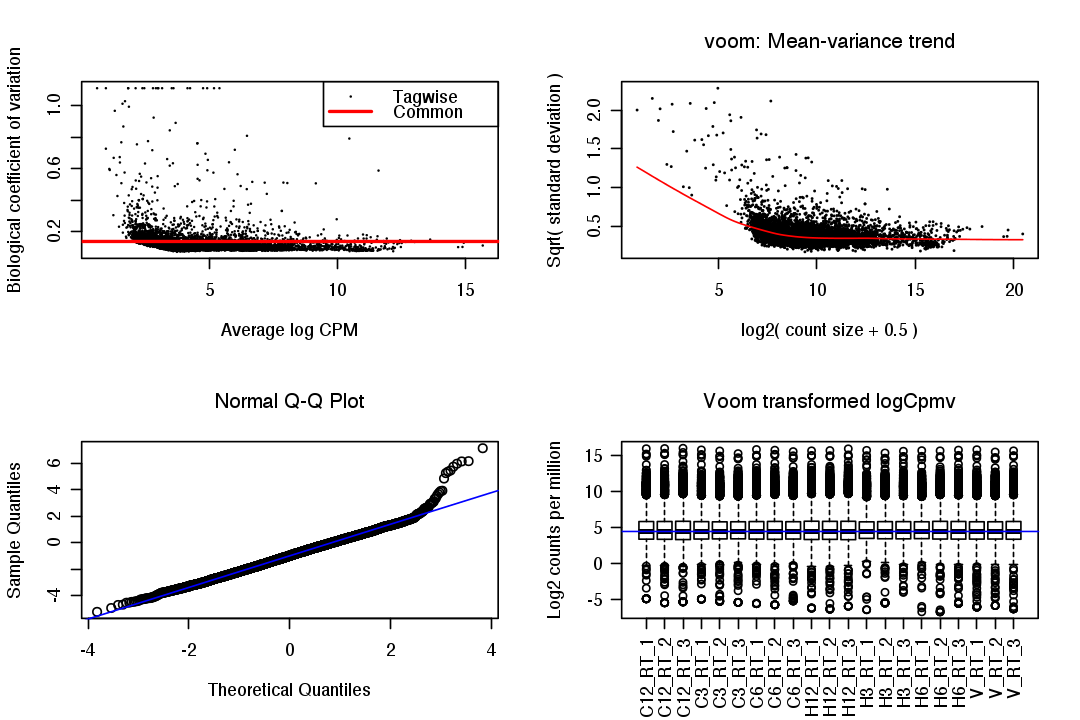

In [111]:
options(repr.plot.width = 9, repr.plot.height = 6)
# pdf("Figures/DE_QC_plots.pdf", width = 9, height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.pmv)
# mean-variance trend
pmv.voom = voom(dgeList.pmv, design.pmv, plot=TRUE)
# QQ-plot
g.pmv <- gof(dgeList.pmv_fit)
z.pmv <- zscoreGamma(g.pmv$gof.statistics,shape=g.pmv$df/2,scale=2)
qqnorm(z.pmv); qqline(z.pmv, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(pmv.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCpmv")
abline(h=median(pmv.voom$E),col="blue")
# dev.off()

And make an MDS plot with Limma:

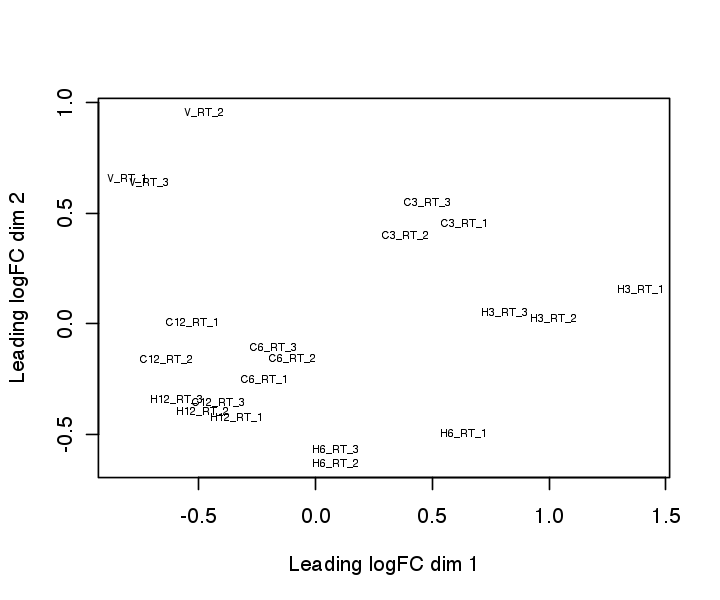

In [112]:
options(repr.plot.width = 6, repr.plot.height = 5)
plotMDS(dgeList.pmv, cex = 0.5)

Can also look at it interactively with Glimma:

In [113]:
glMDSPlot(dgeList.pmv, groups = sampleInfo.pm, labels = sampleInfo.pm$Replicate)

And a custom ggplot2 one:

In [114]:
mdsObj <- plotMDS(dgeList.pmv, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo.pmv, by.x = "replicate", by.y = "Replicate")
mdsObj$Time = factor(mdsObj$Time, levels = c ("virgin", "3hpm", "6hpm", "12hpm"))
mdsObj$Status = factor(mdsObj$Status, levels = c ("virgin", "conspecific", "heterospecific"))

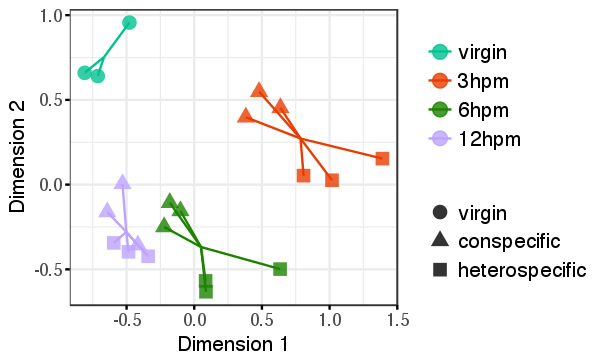

In [115]:
options(repr.plot.width = 5, repr.plot.height = 3)

# pdf("Figures/postmating.MDS.plot.pdf", width = 5, height = 3)
ggscatter(mdsObj, 
              x = "dim1", 
              y = "dim2",
              color = "Time",
              shape = "Status",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
              star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
                scale_colour_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                labs ( x = "Dimension 1", y = "Dimension 2")
# dev.off()

Replicates seem to largely group together in the first component, but two samples (H3_RT_1 and H6_RT_1) deviate from their sisters a bit. We'll consider removing those from the analysis later. For now, let's look at samples correlation. First make a column labeling object for samples/replicates:

In [116]:
sampleColLabeling = subset(sampleInfo.pm, select = c("SampleName", "Replicate"))
sampleColLabeling = filter(sampleColLabeling, grepl("RT", SampleName))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_RT", "C3_RT", "C6_RT", "C12_RT", "H3_RT", "H6_RT", "H12_RT"))

Now plot it:

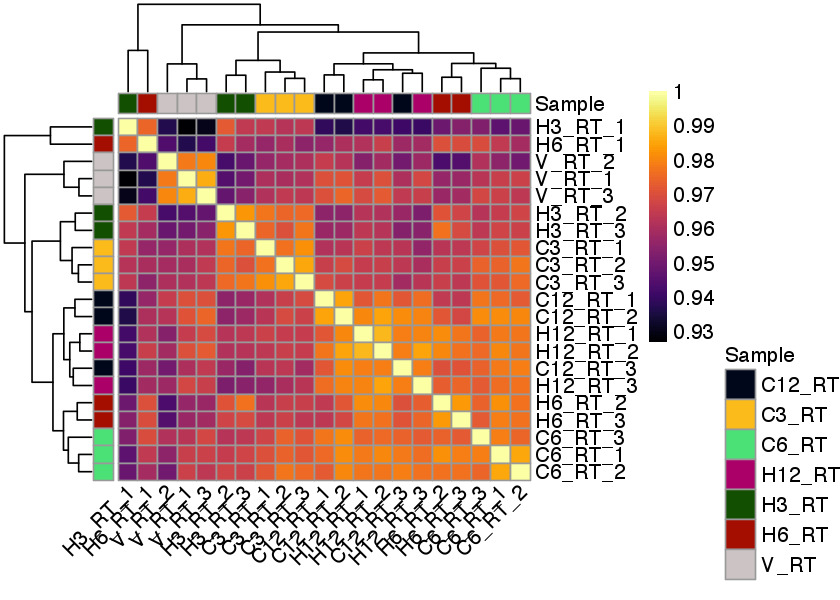

In [117]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.RT+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#00071b","#fbbc1b","#4be177","#aa0067","#134f00","#a40e00","#ccc4c4"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 7, repr.plot.height = 5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 7, 
#   height            = 5,
  fontsize          = 12    
)

To perform pairwise differential expression tests between postmating samples, we need to set up a series of contrasts for the DE test:

In [118]:
time.3hpm <- makeContrasts(C3.vs.H3=H3_RT-C3_RT, levels=design.pmb)
time.6hpm <- makeContrasts(C6.vs.H6=H6_RT-C6_RT, levels=design.pmb)
time.12hpm <- makeContrasts(C12.vs.H12=H12_RT-C12_RT, levels=design.pmb)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the genes with the relevant DE stats.

In [119]:
lrt.pmb.3h <- glmLRT(dgeList.pmb_fit, contrast = time.3hpm)
lrt.pmb.3h.tTags <- topTags(lrt.pmb.3h, n = NULL)
lrt.pmb.3h.tTags.table <- lrt.pmb.3h.tTags$table
sig.het_up.3hpm_list<-subset(lrt.pmb.3h.tTags.table, logFC > 1 & FDR<0.05)$GeneID
sig.het_down.3hpm_list<-subset(lrt.pmb.3h.tTags.table, logFC < -1 & FDR<0.05)$GeneID

In [120]:
lrt.pmb.6h <- glmLRT(dgeList.pmb_fit, contrast = time.6hpm)
lrt.pmb.6h.tTags <- topTags(lrt.pmb.6h, n = NULL)
lrt.pmb.6h.tTags.table <- lrt.pmb.6h.tTags$table
sig.het_up.6hpm_list<-subset(lrt.pmb.6h.tTags.table, logFC > 1 & FDR<0.05)$GeneID
sig.het_down.6hpm_list<-subset(lrt.pmb.6h.tTags.table, logFC < -1 & FDR<0.05)$GeneID

In [121]:
lrt.pmb.12h <- glmLRT(dgeList.pmb_fit, contrast = time.12hpm)
lrt.pmb.12h.tTags <- topTags(lrt.pmb.12h, n = NULL)
lrt.pmb.12h.tTags.table <- lrt.pmb.12h.tTags$table
sig.het_up.12hpm_list<-subset(lrt.pmb.12h.tTags.table, logFC > 1 & FDR<0.05)$GeneID
sig.het_down.12hpm_list<-subset(lrt.pmb.12h.tTags.table, logFC < -1 & FDR<0.05)$GeneID

Now we'll run the contrasts between each postmating sample and the virgin sample:

In [122]:
glmT_C3.v.vir <- glmTreat(dgeList.pmv_fit, coef =3, lfc =1)
glmT_C6.v.vir <- glmTreat(dgeList.pmv_fit, coef =4, lfc =1)
glmT_C12.v.vir <- glmTreat(dgeList.pmv_fit, coef =2, lfc =1)
glmT_H3.v.vir <- glmTreat(dgeList.pmv_fit, coef =6, lfc =1)
glmT_H6.v.vir <- glmTreat(dgeList.pmv_fit, coef =7, lfc =1)
glmT_H12.v.vir <- glmTreat(dgeList.pmv_fit, coef =5, lfc =1)

Extract gene list of DE genes, first upregulated ones....

In [123]:
DE.genes_C3.v.vir_up <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C6.v.vir_up <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C12.v.vir_up <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H3.v.vir_up <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H6.v.vir_up <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H12.v.vir_up <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID

... and downregulated ones...

In [124]:
DE.genes_C3.v.vir_down <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_C6.v.vir_down <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_C12.v.vir_down <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H3.v.vir_down <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H6.v.vir_down <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID
DE.genes_H12.v.vir_down <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < 1)$GeneID

What we can do now is compare and contrasts these individual lists, capture the overlap between them, and plot Venn diagrams. First, let's aggregate by cross type:

In [125]:
RT_UP_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_up, Heterospecific = DE.genes_H3.v.vir_up)
RT_UP_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_up, Heterospecific = DE.genes_H6.v.vir_up)
RT_UP_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_up, Heterospecific = DE.genes_H12.v.vir_up)
RT_Down_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_down, Heterospecific = DE.genes_H3.v.vir_down)
RT_Down_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_down, Heterospecific = DE.genes_H6.v.vir_down)
RT_Down_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_down, Heterospecific = DE.genes_H12.v.vir_down)

Rearrange those into lists of lists, and partition by postmating time-point

In [126]:
# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

Assign names to each combination (i.e., con and het):

In [127]:
names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

Now generate a list of each element:

In [128]:
RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

Now we generate the Venn diagram objects and plot them:

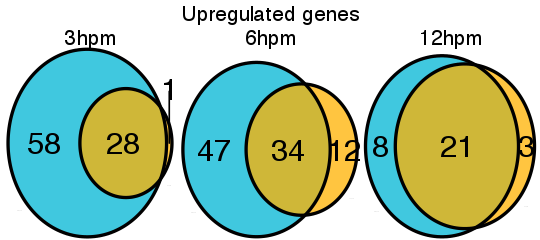

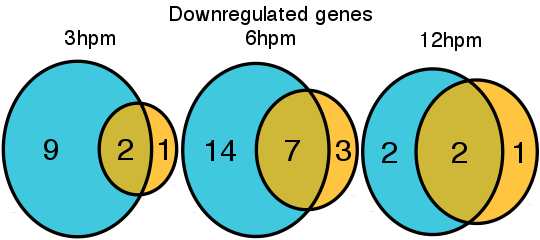

In [129]:
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
# "#3f5a2a",
# "#ffb200","#00b5d4"
options(repr.plot.width = 4.5, repr.plot.height = 2)

# pdf("Figures/Venn_diag.up.pdf", width = 4.5, height = 2)
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag), ncol = 3, top = "Upregulated genes")
# dev.off()

# pdf("Figures/Venn_diag.down.pdf", width = 4.5, height = 2)
grid.arrange(gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag), ncol = 3, top = "Downregulated genes")
# dev.off()

Before we can look at Glimma volcano plots, we need to run the decideTestsDGE for each glmTreat output:

In [130]:
dt_C3.v.vir = decideTestsDGE(glmT_C3.v.vir)
dt_C6.v.vir = decideTestsDGE(glmT_C6.v.vir)
dt_C12.v.vir = decideTestsDGE(glmT_C12.v.vir)
dt_H3.v.vir = decideTestsDGE(glmT_H3.v.vir)
dt_H6.v.vir = decideTestsDGE(glmT_H6.v.vir)
dt_H12.v.vir = decideTestsDGE(glmT_H12.v.vir)

Here's one example of a volcano plot between heterospecific 6hpm samples and virgins:

In [131]:
glXYPlot(x=glmT_H6.v.vir$table$logFC, y=-log10(glmT_H6.v.vir$table$PValue), xlab="logFC", ylab="logodds", status=dt_H6.v.vir, groups=sampleInfo.pm$SampleName, anno = ann.pmv, side.main="gene_name", counts = dgeList.pmv)

##### Analysis of upregulated genes in the female RT:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [132]:
RT_upregulated_genes = unique(unlist(c(RT_UP_3hrs_elements, RT_UP_6hrs_elements, RT_UP_12hrs_elements)))
message(paste("There are ", length(RT_upregulated_genes), " upregulated genes", sep =""))
RT_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% RT_upregulated_genes)

RT_upregulated_genes_matrix = RT_upregulated_genes_matrix[ , grepl("RT", names(RT_upregulated_genes_matrix))]
RT_upregulated_genes_matrix_con = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_upregulated_genes_matrix_het = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

There are 128 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

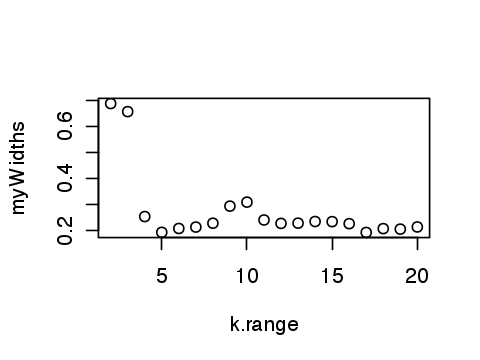

In [133]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_upregulated_genes_matrix)

Cruedly, it looks like 6 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [134]:
data = RT_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=6)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [135]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


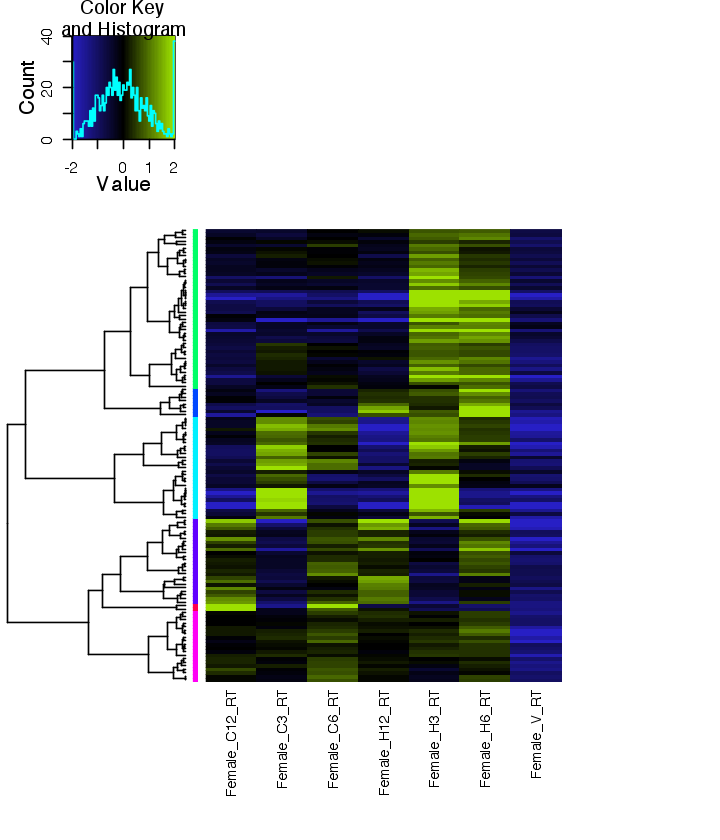

In [136]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [137]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_PM_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [138]:
conSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
hetSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("3", df.conSub$variable), "3hpm", ifelse(grepl("6", df.conSub$variable), "6hpm", ifelse(grepl("12", df.conSub$variable), "12hpm","virgin")))
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("3", df.hetSub$variable), "3hpm", ifelse(grepl("6", df.hetSub$variable), "6hpm", ifelse(grepl("12", df.hetSub$variable), "12hpm","virgin")))
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

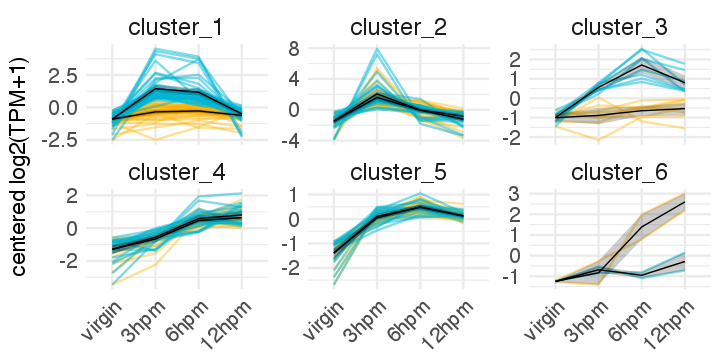

In [139]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3", 
                                                   "cluster_4", 
                                                   "cluster_5", 
#                                                    "cluster_6", 
#                                                    "cluster_7", 
                                                   "cluster_6"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/cluster_groupings.pdf", width = 6, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=45,hjust=1, size = 12),
         axis.text.y = element_text(size = 12),
         axis.title.x = element_blank(),
         axis.title.y = element_text(size = 13),
         strip.text = element_text(size = 14)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

Let's output individual gene plots of all thesegenes, partitioned by cluster:

In [140]:
# DE.genes_up_C1_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_up_C1_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C1_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C2_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_2"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_up_C2_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C2_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C3_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_3"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_up_C3_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C3_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C4_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_4"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_up_C4_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C4_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C5_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_5"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_up_C5_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C5_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C6_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_6"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_up_C6_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C6_boxPlots, nrow = 3, ncol =1))

Let's look at GO enrichment across all upregulated genes:

In [141]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [142]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


And can plot them as before:

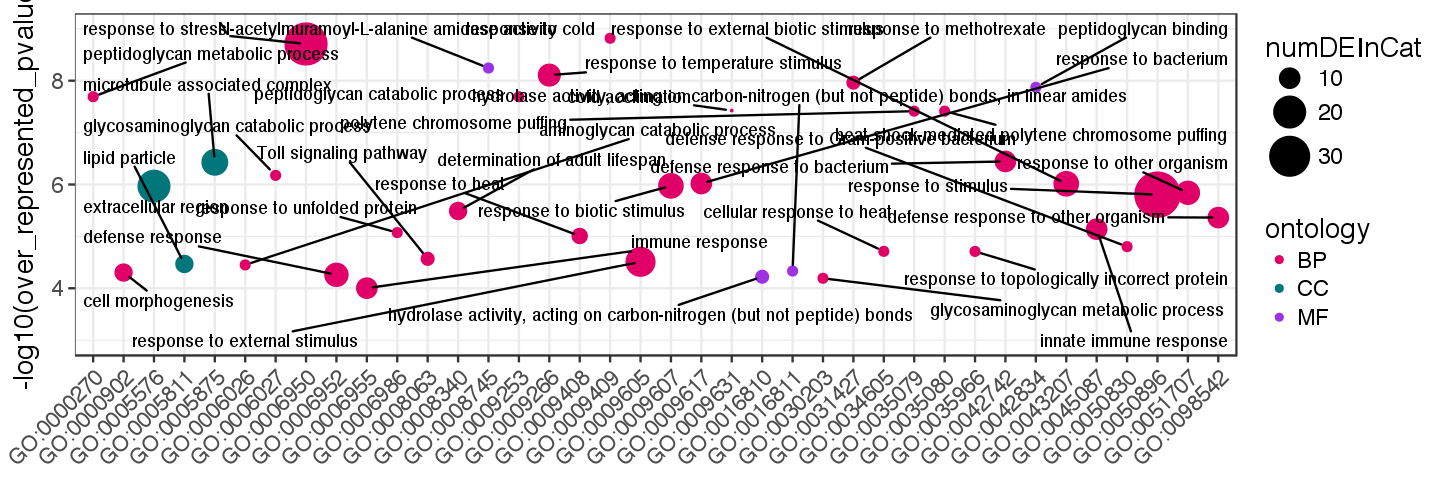

In [143]:
options(repr.plot.width = 12, repr.plot.height = 4)
ggplot(subset(enrich_result_table, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point() +
#     facet_grid(.~ontology, scale = "free_x") +
    xlab(NULL) + 
    geom_text_repel(data = subset(enrich_result_table, over_represented_FDR < 0.05), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3.5) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

Now let's run the GO enrichment analysis for each cluster. First we create a factor labeling object:

In [144]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(GO_enrichment_data, "Results/GO_analyses/GO_results-clusters_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_2" "cluster_4"

We can output a PDF of gene plots for different categories of upregulated genes. First, we'll create lists of DE genes that are unique to either con- or heterospecific condition, or are shared:

In [145]:
hetUnique.3hpm = setdiff(intersect(DE.genes_H3.v.vir_up, sig.het_up.3hpm_list), DE.genes_C3.v.vir_up)
hetUnique.6hpm = setdiff(intersect(DE.genes_H6.v.vir_up, sig.het_up.6hpm_list), DE.genes_C6.v.vir_up)
hetUnique.12hpm = setdiff(intersect(DE.genes_H12.v.vir_up, sig.het_up.12hpm_list), DE.genes_C12.v.vir_up)
DE.genes_up_het_unique = unique(c(hetUnique.3hpm, hetUnique.6hpm, hetUnique.12hpm))

In [146]:
conUnique.3hpm = setdiff(intersect(DE.genes_C3.v.vir_up, sig.het_down.3hpm_list), DE.genes_H3.v.vir_up)
conUnique.6hpm = setdiff(intersect(DE.genes_C6.v.vir_up, sig.het_down.6hpm_list), DE.genes_H6.v.vir_up)
conUnique.12hpm = setdiff(intersect(DE.genes_C12.v.vir_up, sig.het_down.12hpm_list), DE.genes_H12.v.vir_up)
DE.genes_up_con_unique = unique(c(conUnique.3hpm, conUnique.6hpm, conUnique.12hpm))

In [147]:
shared.3hpm = setdiff(intersect(DE.genes_C3.v.vir_up, DE.genes_H3.v.vir_up), c(sig.het_up.3hpm_list, sig.het_down.3hpm_list))
shared.6hpm = setdiff(intersect(DE.genes_C6.v.vir_up, DE.genes_H6.v.vir_up), c(sig.het_up.6hpm_list, sig.het_down.6hpm_list))
shared.12hpm = setdiff(intersect(DE.genes_C12.v.vir_up, DE.genes_H12.v.vir_up), c(sig.het_up.12hpm_list, sig.het_down.12hpm_list))
DE.genes_up_shared = unique(c(shared.3hpm, shared.6hpm, shared.12hpm))

Here we'll output these plots:

In [148]:
# DE.genes_up_con_specific_boxPlots = suppressMessages(lapply(DE.genes_up_con_unique, geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/Upregulated_genes_in_con_condition.pdf", marrangeGrob(grobs = DE.genes_up_con_specific_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_het_specific_boxPlots = suppressMessages(lapply(DE.genes_up_het_unique, geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/Upregulated_genes_in_het_condition.pdf", marrangeGrob(grobs = DE.genes_up_het_specific_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_shared_boxPlots = suppressMessages(lapply(DE.genes_up_shared, geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/Upregulated_genes_shared.pdf", marrangeGrob(grobs = DE.genes_up_shared_boxPlots, nrow = 3, ncol =1))

We can also run GO analyses on these three groups separately (actually just on the shared ones; either specific group has no enrichment):

In [149]:
## Shared
cat_genes_vec = as.integer(features_with_GO %in% DE.genes_up_shared)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
Up_shared.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(Up_shared.enrich_result_table$category, get_GO_term_descr))
Up_shared.enrich_result_table$go_term = descr
Up_shared.enrich_result_table$factor = go_enrich_factor
write.table(Up_shared.enrich_result_table, "Results/GO_analyses/GO_results-upregulated_genes_shared_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


###### Immune and JNK pathway genes that are uniquely upregulated in the heterospecific condition:

Immune genes feature prominantly among upregulated genes that are specific to the heterospecific condition. Let's make an individual gene plot for those. First, some edits for some data frame:

In [150]:
melOrthsAll$mel_GeneSymbol = gsub("CG12780, ", "", melOrthsAll$mel_GeneSymbol)
annot.sum$SwissProt_BlastX_Description = gsub("Phospholipase A2 isozymes PA3A/PA3B/PA5", "Phospholipase", annot.sum$SwissProt_BlastX_Description)

Now generate a grid plot:

In [153]:
options(repr.plot.width = 9, repr.plot.height = 5)
attacin = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0207711")
defensin = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0209590")
cecropin = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0017816") + labs(title = "Cec2B", subtitle = "Cecropin-2")
gnbp = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0207804") + labs(title = "GJ20666 (GNBP-like3)", subtitle = "Gram-negative bacteria-binding\nprotein 3")
relish = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0210579")
immune_genes_plots = plot_grid(attacin, defensin, cecropin, gnbp, relish, ncol = 3, align = "h")

ALso for JNK pathway genes:

In [154]:
options(repr.plot.width = 6, repr.plot.height = 5)
gadd45 = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0208196") + labs(title = "GJ21062 (Gadd45)", subtitle = "Growth arrest and DNA-dammage\ninducible protein")
ets21c = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0206847")
GIIIspla2 = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0206553") 
socs = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0197572")
jnkStat_genes_plots = plot_grid(gadd45, ets21c, GIIIspla2, socs, ncol = 2, align = "h")

Now combine them:

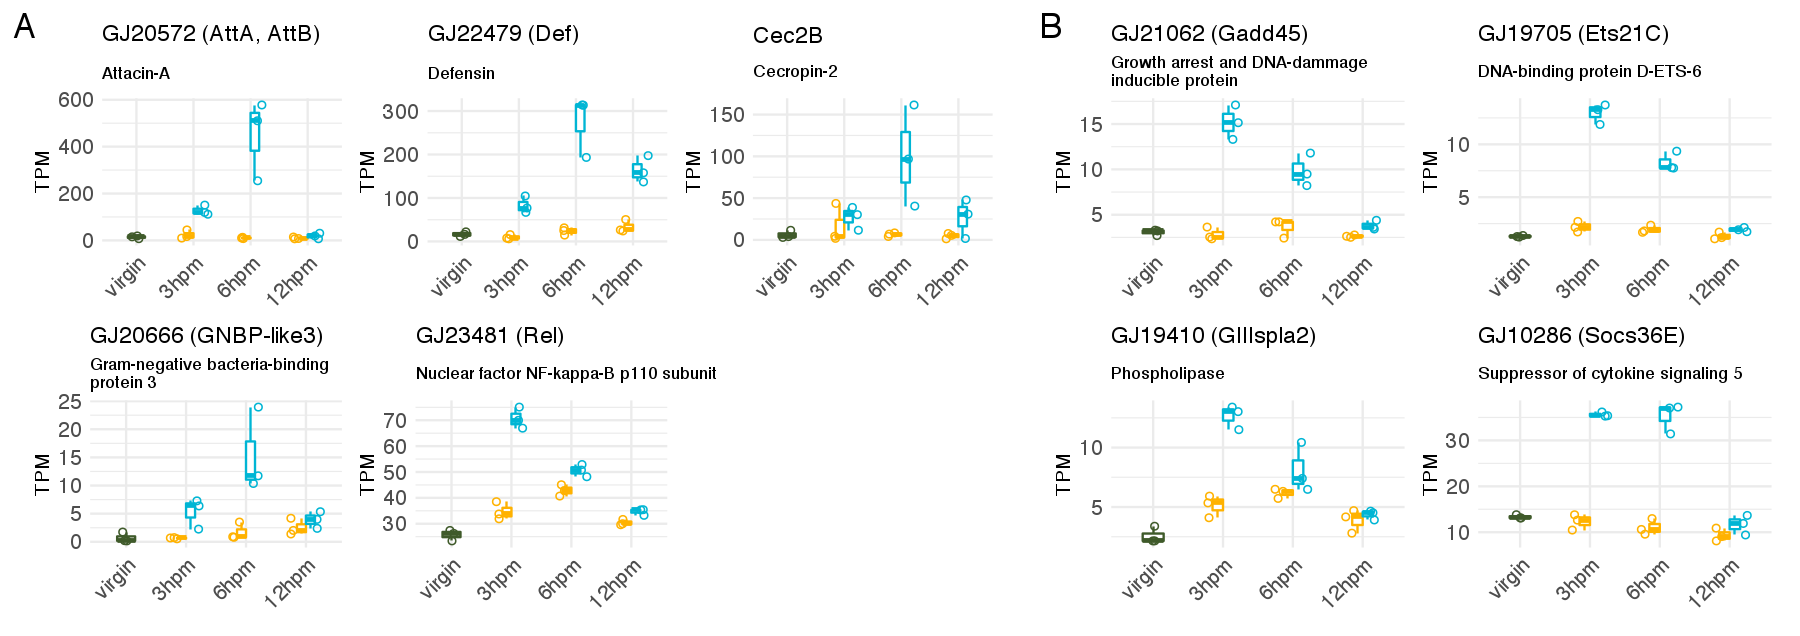

In [155]:
options(repr.plot.width = 15, repr.plot.height = 5.3)
# pdf("Figures/immune_and_jnkStat_gene_plots.pdf", height = 5.3, width = 15)
plot_grid(immune_genes_plots, jnkStat_genes_plots, ncol = 2, labels = "AUTO", rel_widths = c(1.33, 1), label_size = 20, scale = c(0.95, 0.95))
# dev.off()

##### Analysis of downregulated genes in the female RT:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [156]:
RT_downregulated_genes = unique(unlist(c(RT_Down_3hrs_elements, RT_Down_6hrs_elements, RT_Down_12hrs_elements)))
message(paste("There are ", length(RT_downregulated_genes), " downregulated genes", sep =""))
RT_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% RT_downregulated_genes)

RT_downregulated_genes_matrix = RT_downregulated_genes_matrix[ , grepl("RT", names(RT_downregulated_genes_matrix))]
RT_downregulated_genes_matrix_con = subset(RT_downregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_downregulated_genes_matrix_het = subset(RT_downregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

There are 31 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

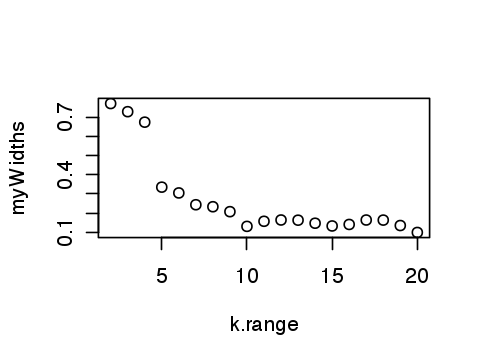

In [157]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_downregulated_genes_matrix)

Cruedly, it looks like 5 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [158]:
data = RT_downregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=6)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [159]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


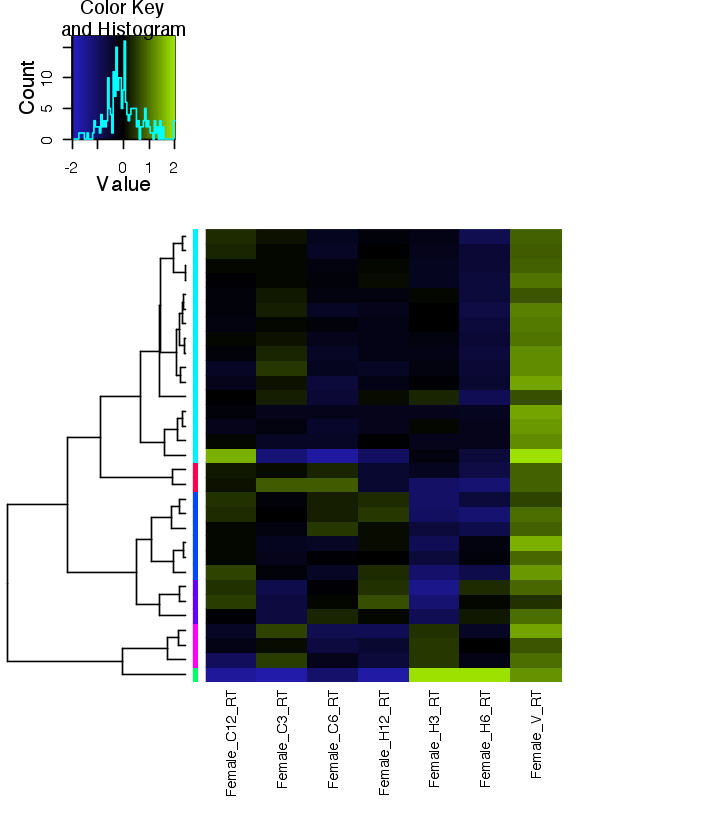

In [160]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [161]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_PM_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [162]:
conSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
hetSub = subset(cluster_PM_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("3", df.conSub$variable), "3hpm", ifelse(grepl("6", df.conSub$variable), "6hpm", ifelse(grepl("12", df.conSub$variable), "12hpm","virgin")))
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("3", df.hetSub$variable), "3hpm", ifelse(grepl("6", df.hetSub$variable), "6hpm", ifelse(grepl("12", df.hetSub$variable), "12hpm","virgin")))
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

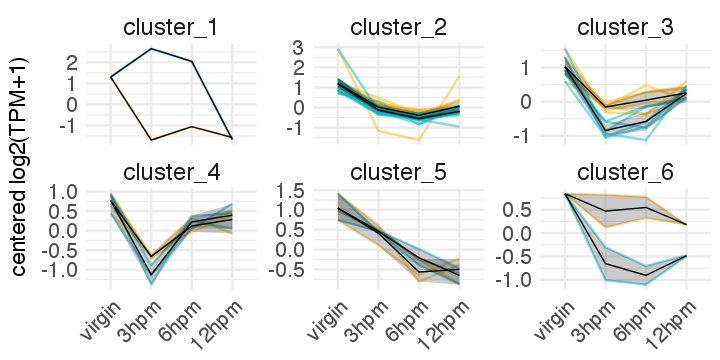

In [163]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3", 
                                                   "cluster_4",
                                                   "cluster_5",
                                                   "cluster_6" 
#                                                    "cluster_7", 
                                                  ))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/cluster_groupings_down.pdf", width = 6, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.5,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=45,hjust=1, size = 12),
         axis.text.y = element_text(size = 12),
         axis.title.x = element_blank(),
         axis.title.y = element_text(size = 13),
         strip.text = element_text(size = 14)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

Let's output individual gene plots of all thesegenes, partitioned by cluster:

In [164]:
# DE.genes_down_C1_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_down_C1_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C1_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C2_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_2"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_down_C2_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C2_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C3_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_3"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_down_C3_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C3_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C4_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_4"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_down_C4_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C4_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C5_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_5"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_down_C5_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C5_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C6_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_6"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.genes_down_C6_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C6_boxPlots, nrow = 3, ncol =1))

Let's look at GO enrichment across all upregulated genes:

In [165]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
subset(enrich_result_table, over_represented_FDR < 0.05)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term


No significant GO terms.

### Ovaries post-mating contrasts:

Create OV-specific count matrix 

In [166]:
counts_bt2.fbgn.OV = subset(counts_bt2.fbgn, select=grepl("OV", colnames(counts_bt2.fbgn)))
colnames(counts_bt2.fbgn.OV) = gsub("Female_", "", colnames(counts_bt2.fbgn.OV))

Now let's filter low expression genes within a minimum cpm of 2:

In [167]:
cpm_bt2.fbgn.OV <- cpm(counts_bt2.fbgn.OV)
thresh_OV.bt2.fbgn <- cpm_bt2.fbgn.OV > 10

countsKeep_OV.bt2.fbgn <- rowSums(thresh_OV.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.OV <- counts_bt2.fbgn.OV[countsKeep_OV.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.OV)

## Clean-up
rm(cpm_bt2.fbgn.OV, countsKeep_OV.bt2.fbgn, thresh_OV.bt2.fbgn)

[1] 6709    6

We'll also subset the samplesInfo object to only include the RT samples:

In [168]:
sampleInfo.ov = subset(sampleInfo, Tissue == "ovaries")
sampleInfo.ov$SampleName = gsub("Female_", "", sampleInfo.ov$SampleName)
sampleInfo.ov$Replicate = gsub("Female_", "", sampleInfo.ov$Replicate)

#### Comparing each postmating time point to the virgin ovary sample:

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors:

In [169]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.ov$Status, sampleInfo.ov$Time, sep="."))
sampleInfo.ov <- cbind(sampleInfo.ov, Group=Status.time)
sampleInfo.ov$Group <- relevel(sampleInfo.ov$Group, ref = "virgin.virgin")

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [170]:
groups.ovb <- factor(sampleInfo.ov$SampleName)
design.ovb <- model.matrix(~ 0 + groups.ovb)
colnames(design.ovb) <- levels(groups.ovb)
rownames(design.ovb) <- sampleInfo.ov$Replicate

Create edgeR DE object and run glmFit

In [171]:
dgeList.ov <- DGEList(counts = countsFiltered_bt2.fbgn.OV, group = groups.ovb)
dgeList.ov <- calcNormFactors(dgeList.ov)
dgeList.ov <- estimateCommonDisp(dgeList.ov)
dgeList.ov <- estimateTagwiseDisp(dgeList.ov)
dgeList.ov_fit <- glmFit(dgeList.ov, design.ovb)

Let's add the annotation information to this fit object:

In [172]:
# Extract annotation for genes in the fit object
ann.ov = subset(Annots, FBgn_ID %in% rownames(dgeList.ov_fit))
ann.ov = subset(ann.ov, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.ov = data.frame(lapply(ann.ov, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.ov = ann.ov[match(rownames(dgeList.ov_fit), ann.ov$FBgn_ID),]
# convert factors to characters, again
ann.ov <- data.frame(lapply(ann.ov, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.ov) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.ov$GeneID==rownames(dgeList.ov_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.ov_fit$genes = ann.ov


TRUE 
6709 

Also, check the tagwise dispersion summary:

In [173]:
summary(dgeList.ov$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01657 0.01988 0.02188 0.02716 0.02801 1.24500 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

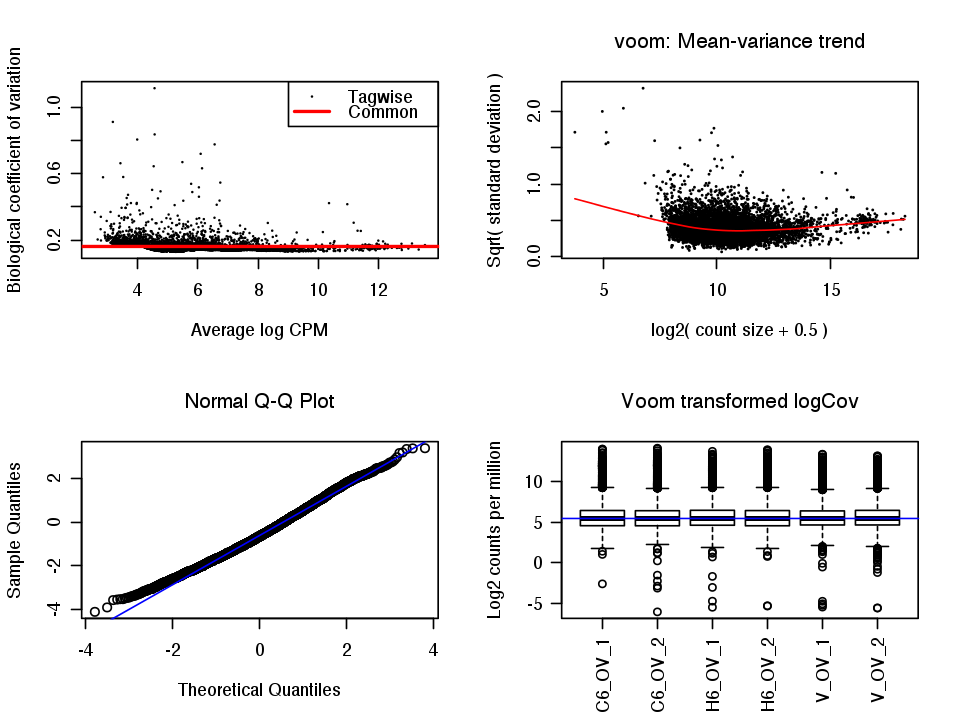

In [174]:
options(repr.plot.width = 8, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.ov)
# mean-variance trend
ov.voom = voom(dgeList.ov, design.ovb, plot=TRUE)
# QQ-plot
g.ov <- gof(dgeList.ov_fit)
z.ov <- zscoreGamma(g.ov$gof.statistics,shape=g.ov$df/2,scale=2)
qqnorm(z.ov); qqline(z.ov, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(ov.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCov")
abline(h=median(ov.voom$E),col="blue")

And make an MDS plot with Limma:

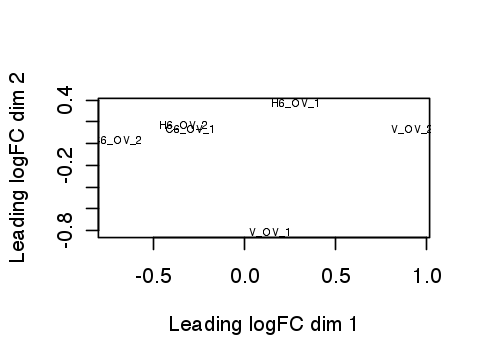

In [175]:
options(repr.plot.width = 4, repr.plot.height = 3)
plotMDS(dgeList.ov, cex = 0.5)

Can also look at int interactively with Glimma:

In [176]:
glMDSPlot(dgeList.ov, groups = sampleInfo.ov, labels = sampleInfo.ov$Replicate)

Let's look at samples correlation:

In [177]:
sampleColLabeling = subset(sampleInfo.ov, select = c("SampleName", "Replicate"))
sampleColLabeling = filter(sampleColLabeling, grepl("OV", SampleName))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_OV", "C6_OV", "H6_OV"))

Now plot it:

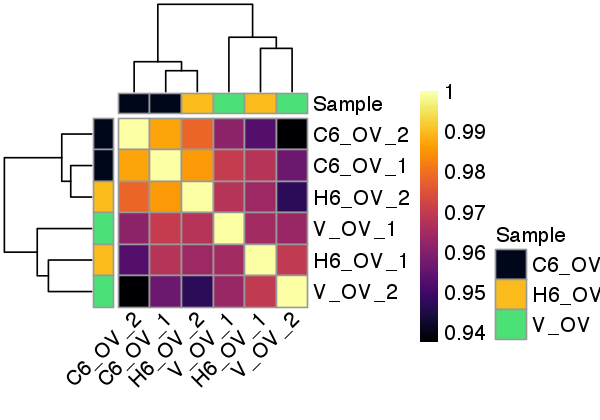

In [178]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.OV+1)
colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#00071b","#fbbc1b","#4be177"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 5, repr.plot.height = 3.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 7, 
#   height            = 5,
  fontsize          = 12    
)

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference:

In [179]:
het.v.vir <- makeContrasts(hOV.vs.vOV=H6_OV-V_OV, levels=design.ovb)
con.v.vir <- makeContrasts(hOV.vs.cOV=C6_OV-V_OV, levels=design.ovb)
het.v.con <- makeContrasts(hOV.vs.cOV=H6_OV-C6_OV, levels=design.ovb)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

In [180]:
lrt_het.v.vir <- glmLRT(dgeList.ov_fit, contrast = het.v.vir)
lrt_het.v.vir.tTags <- topTags(lrt_het.v.vir, n = NULL)
lrt_het.v.vir.tTags.table <- lrt_het.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_het.v.vir.list_up<-subset(lrt_het.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_het.v.vir.list_down<-subset(lrt_het.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(OV_het.v.vir.list_up), " genes are upregulated in the heterospecific cross, and ", length(OV_het.v.vir.list_down), " are downregualted" ,sep = "")

[1] "28 genes are upregulated in the heterospecific cross, and 10 are downregualted"

In [181]:
lrt_con.v.vir <- glmLRT(dgeList.ov_fit, contrast = con.v.vir)
lrt_con.v.vir.tTags <- topTags(lrt_con.v.vir, n = NULL)
lrt_con.v.vir.tTags.table <- lrt_con.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_con.v.vir.list_up<-subset(lrt_con.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_con.v.vir.list_down<-subset(lrt_con.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(OV_con.v.vir.list_up), " genes are upregulated in the conspecific cross, and ", length(OV_con.v.vir.list_down), " are downregualted" ,sep = "")

[1] "67 genes are upregulated in the conspecific cross, and 14 are downregualted"

In [182]:
lrt_het.v.con <- glmLRT(dgeList.ov_fit, contrast = het.v.con)
lrt_het.v.con.tTags <- topTags(lrt_het.v.con, n = NULL)
lrt_het.v.con.tTags.table <- lrt_het.v.con.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_het.v.con.list_up<-subset(lrt_het.v.con.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_het.v.con.list_down<-subset(lrt_het.v.con.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(OV_het.v.con.list_up), " genes are upregulated in the heterospecific cross, and ", length(OV_het.v.con.list_down), " are downregualted" ,sep = "")

[1] "5 genes are upregulated in the heterospecific cross, and 9 are downregualted"

In [183]:
length(unique(c(OV_het.v.vir.list_up, OV_het.v.vir.list_down, OV_con.v.vir.list_up, OV_con.v.vir.list_down, OV_het.v.con.list_up, OV_het.v.con.list_down)))

[1] 98

##### Analysis of upregulated genes in the female ovary:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [184]:
OV_upregulated_genes = unique(c(OV_het.v.vir.list_up, OV_con.v.vir.list_up))
message(paste("There are ", length(OV_upregulated_genes), " upregulated genes", sep =""))
OV_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% OV_upregulated_genes)

OV_upregulated_genes_matrix = OV_upregulated_genes_matrix[ , grepl("OV", names(OV_upregulated_genes_matrix))]
OV_upregulated_genes_matrix_con = subset(OV_upregulated_genes_matrix, select = c("Female_V_OV", "Female_C6_OV"))
OV_upregulated_genes_matrix_het = subset(OV_upregulated_genes_matrix, select = c("Female_V_OV", "Female_H6_OV"))

There are 72 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

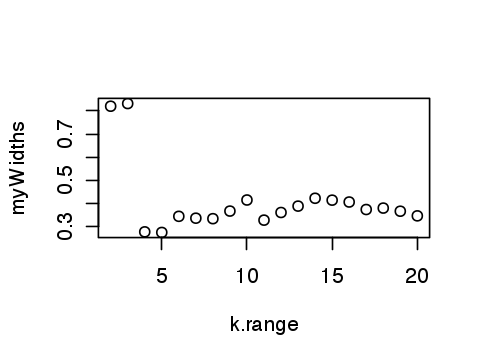

In [185]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(OV_upregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [186]:
data = OV_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=3)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [187]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


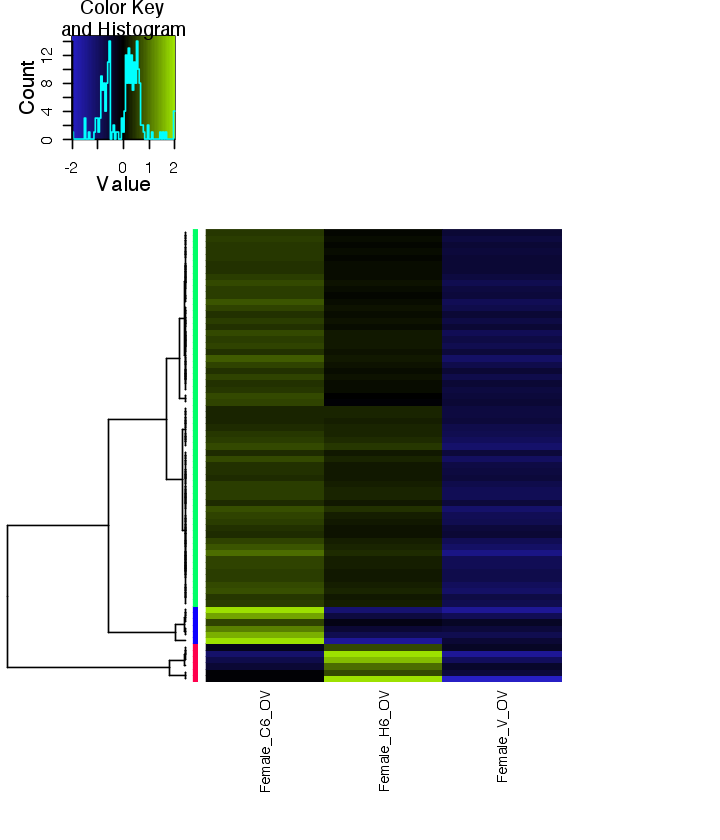

In [188]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [189]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_OV_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [190]:
conSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_C6_OV"))
hetSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_H6_OV"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

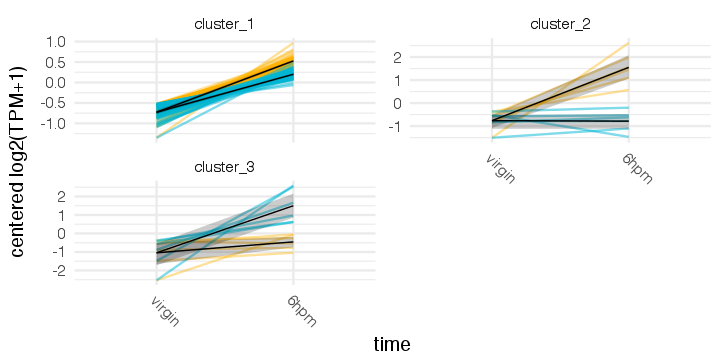

In [191]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those two clusters here:

In [192]:
## Cluster 1
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C1.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C1.enrich_result_table$category, get_GO_term_descr))
C1.enrich_result_table$go_term = descr
write.table(C1.enrich_result_table, "Results/GO_analyses/GO_results-ovary_cluster1_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [193]:
## Cluster 2
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_2"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C2.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C2.enrich_result_table$category, get_GO_term_descr))
C2.enrich_result_table$go_term = descr
write.table(C2.enrich_result_table, "Results/GO_analyses/GO_results-ovary_cluster2_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [194]:
## Cluster 3
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_3"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C3.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C3.enrich_result_table$category, get_GO_term_descr))
C3.enrich_result_table$go_term = descr
write.table(C3.enrich_result_table, "Results/GO_analyses/GO_results-ovary_cluster3_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Let's look at GO enrichment across all upregulated genes:

In [195]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
enrich_result_table$factor = go_enrich_factor
write.table(enrich_result_table, "Results/GO_analyses/GO_results-ovary_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


##### Analysis of downregulated genes in the female ovary:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [196]:
OV_downregulated_genes = unique(c(OV_het.v.vir.list_down, OV_con.v.vir.list_down))
message(paste("There are ", length(OV_downregulated_genes), " downregulated genes", sep =""))
OV_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% OV_downregulated_genes)

OV_downregulated_genes_matrix = OV_downregulated_genes_matrix[ , grepl("OV", names(OV_downregulated_genes_matrix))]
OV_downregulated_genes_matrix_con = subset(OV_downregulated_genes_matrix, select = c("Female_V_OV", "Female_C6_OV"))
OV_downregulated_genes_matrix_het = subset(OV_downregulated_genes_matrix, select = c("Female_V_OV", "Female_H6_OV"))

There are 23 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

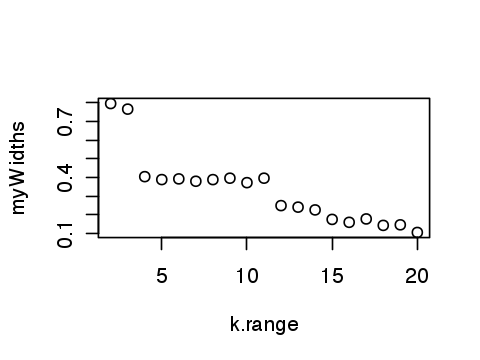

In [197]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(OV_downregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [198]:
data = OV_downregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=3)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [199]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


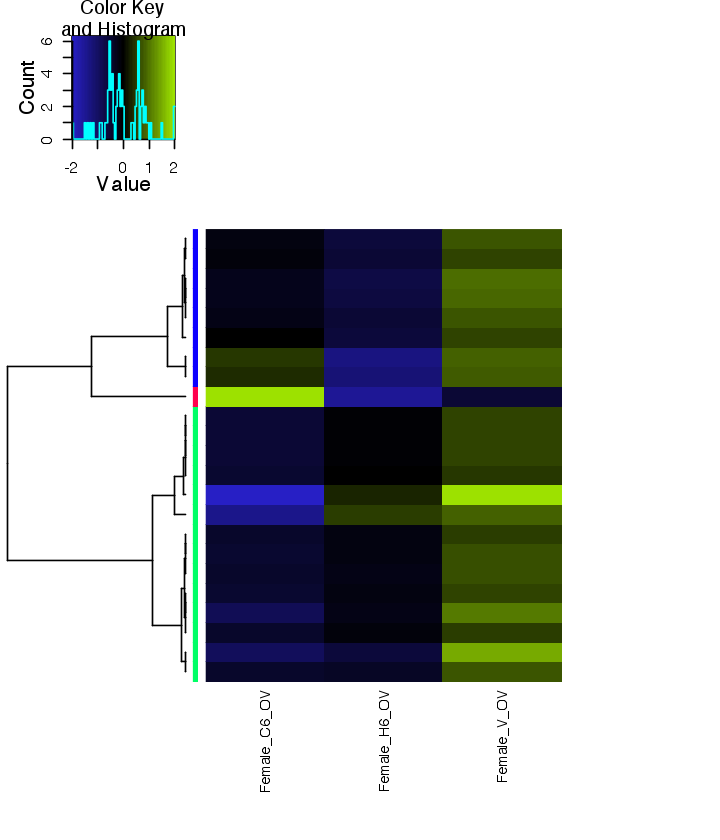

In [200]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [201]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_OV_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [202]:
conSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_C6_OV"))
hetSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_H6_OV"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

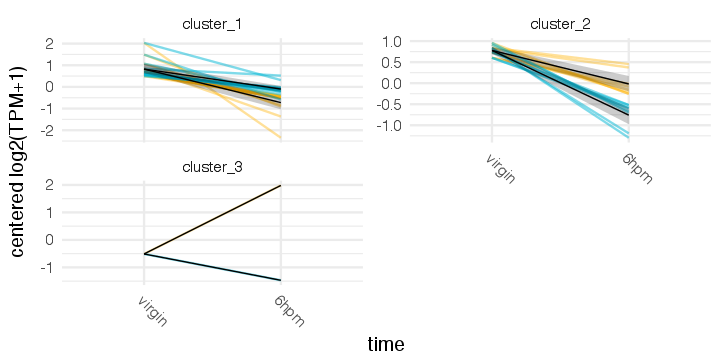

In [203]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those two clusters here:

In [204]:
## Cluster 1
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C1.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C1.enrich_result_table$category, get_GO_term_descr))
C1.enrich_result_table$go_term = descr
write.table(C1.enrich_result_table, "Results/GO_analyses/GO_results-ovary_cluster1_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [205]:
## Cluster 2
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_2"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C2.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C2.enrich_result_table$category, get_GO_term_descr))
C2.enrich_result_table$go_term = descr
write.table(C2.enrich_result_table, "Results/GO_analyses/GO_results-ovary_cluster2_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [206]:
## Cluster 3
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_3"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C3.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C3.enrich_result_table$category, get_GO_term_descr))
C3.enrich_result_table$go_term = descr
write.table(C3.enrich_result_table, "Results/GO_analyses/GO_results-ovary_cluster3_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Let's look at GO enrichment across all upregulated genes:

In [207]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
enrich_result_table$factor = go_enrich_factor
write.table(enrich_result_table, "Results/GO_analyses/GO_results-ovary_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


### Head post-mating contrasts:

Create H-specific count matrix 

In [208]:
counts_bt2.fbgn.H = subset(counts_bt2.fbgn, select=grepl("_H_", colnames(counts_bt2.fbgn)))
colnames(counts_bt2.fbgn.H) = gsub("Female_", "", colnames(counts_bt2.fbgn.H))

Now let's filter low expression genes within a minimum cpm of 2:

In [209]:
cpm_bt2.fbgn.H <- cpm(counts_bt2.fbgn.H)
thresh_H.bt2.fbgn <- cpm_bt2.fbgn.H > 10

countsKeep_H.bt2.fbgn <- rowSums(thresh_H.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.H <- counts_bt2.fbgn.H[countsKeep_H.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.H)

## Clean-up
rm(cpm_bt2.fbgn.H, countsKeep_H.bt2.fbgn, thresh_H.bt2.fbgn)

[1] 7072    6

We'll also subset the samplesInfo object to only include the RT samples:

In [210]:
sampleInfo.h = subset(sampleInfo, Tissue == "head")
sampleInfo.h$SampleName = gsub("Female_", "", sampleInfo.h$SampleName)
sampleInfo.h$Replicate = gsub("Female_", "", sampleInfo.h$Replicate)

#### Comparing each postmating time point to the virgin ovary sample:

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors:

In [211]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.h$Status, sampleInfo.h$Time, sep="."))
sampleInfo.h <- cbind(sampleInfo.h, Group=Status.time)
sampleInfo.h$Group <- relevel(sampleInfo.h$Group, ref = "virgin.virgin")

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [212]:
groups.hb <- factor(sampleInfo.h$SampleName)
design.hb <- model.matrix(~ 0 + groups.hb)
colnames(design.hb) <- levels(groups.hb)
rownames(design.hb) <- sampleInfo.h$Replicate

Create edgeR DE object and run glmFit

In [213]:
dgeList.h <- DGEList(counts = countsFiltered_bt2.fbgn.H, group = groups.hb)
dgeList.h <- calcNormFactors(dgeList.h)
dgeList.h <- estimateCommonDisp(dgeList.h)
dgeList.h <- estimateTagwiseDisp(dgeList.h)
dgeList.h_fit <- glmFit(dgeList.h, design.hb)

Let's add the annotation information to this fit object:

In [214]:
# Extract annotation for genes in the fit object
ann.h = subset(Annots, FBgn_ID %in% rownames(dgeList.h_fit))
ann.h = subset(ann.h, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.h = data.frame(lapply(ann.h, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.h = ann.h[match(rownames(dgeList.h_fit), ann.h$FBgn_ID),]
# convert factors to characters, again
ann.h <- data.frame(lapply(ann.h, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.h) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.h$GeneID==rownames(dgeList.h_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.h_fit$genes = ann.h


TRUE 
7072 

Also, check the tagwise dispersion summary:

In [215]:
summary(dgeList.h$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005910 0.008796 0.010420 0.012250 0.012160 0.787000 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

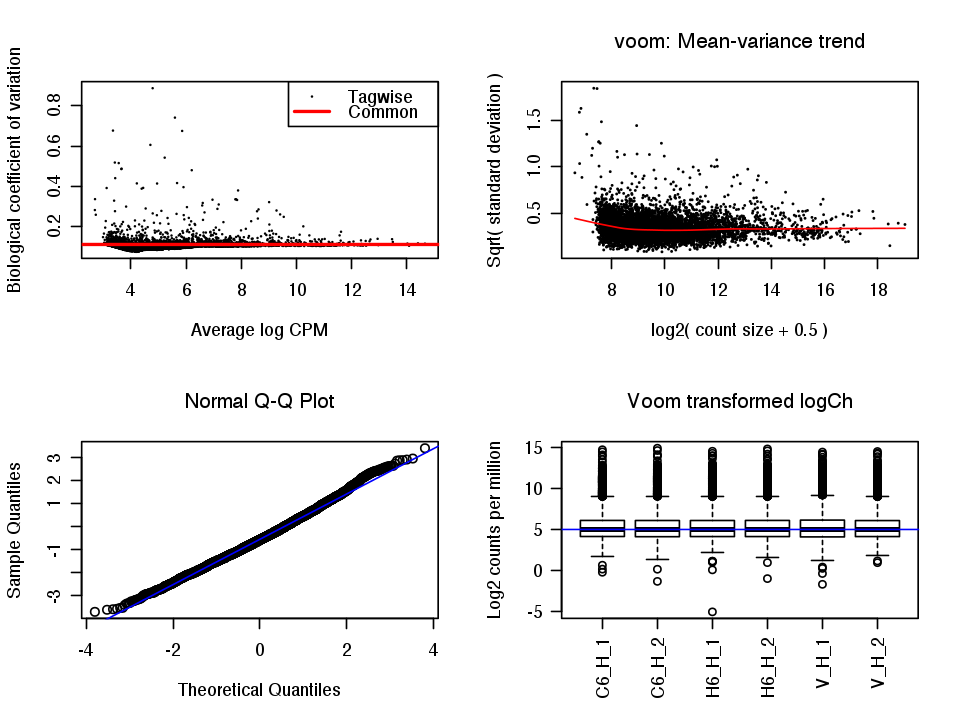

In [216]:
options(repr.plot.width = 8, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.h)
# mean-variance trend
h.voom = voom(dgeList.h, design.hb, plot=TRUE)
# QQ-plot
g.h <- gof(dgeList.h_fit)
z.h <- zscoreGamma(g.h$gof.statistics,shape=g.h$df/2,scale=2)
qqnorm(z.h); qqline(z.h, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(h.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCh")
abline(h=median(h.voom$E),col="blue")

And make an MDS plot with Limma:

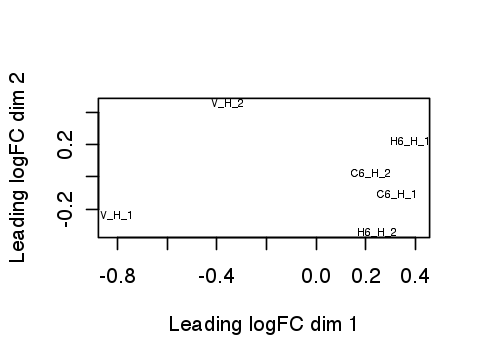

In [217]:
options(repr.plot.width = 4, repr.plot.height = 3)
plotMDS(dgeList.h, cex = 0.5)

Can also look at int interactively with Glimma:

In [218]:
glMDSPlot(dgeList.h, groups = sampleInfo.h, labels = sampleInfo.h$Replicate)

Let's look at samples correlation:

In [219]:
sampleColLabeling = subset(sampleInfo.h, select = c("SampleName", "Replicate"))
sampleColLabeling = filter(sampleColLabeling, grepl("H", SampleName))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_H", "C6_H", "H6_H"))

Now plot it:

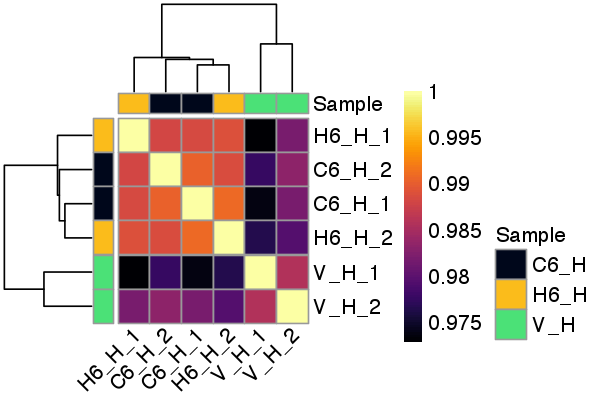

In [220]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.H+1)
colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#00071b","#fbbc1b","#4be177"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 5, repr.plot.height = 3.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 7, 
#   height            = 5,
  fontsize          = 12    
)

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference:

In [221]:
het.v.vir <- makeContrasts(hH.vs.vH=H6_H-V_H, levels=design.hb)
con.v.vir <- makeContrasts(hH.vs.cH=C6_H-V_H, levels=design.hb)
het.v.con <- makeContrasts(hH.vs.cH=H6_H-C6_H, levels=design.hb)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

In [222]:
lrt_het.v.vir <- glmLRT(dgeList.h_fit, contrast = het.v.vir)
lrt_het.v.vir.tTags <- topTags(lrt_het.v.vir, n = NULL)
lrt_het.v.vir.tTags.table <- lrt_het.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_het.v.vir.list_up<-subset(lrt_het.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_het.v.vir.list_down<-subset(lrt_het.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(H_het.v.vir.list_up), " genes are upregulated in the heterospecific cross, and ", length(H_het.v.vir.list_down), " are downregualted" ,sep = "")

[1] "39 genes are upregulated in the heterospecific cross, and 37 are downregualted"

In [223]:
lrt_con.v.vir <- glmLRT(dgeList.h_fit, contrast = con.v.vir)
lrt_con.v.vir.tTags <- topTags(lrt_con.v.vir, n = NULL)
lrt_con.v.vir.tTags.table <- lrt_con.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_con.v.vir.list_up<-subset(lrt_con.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_con.v.vir.list_down<-subset(lrt_con.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(H_con.v.vir.list_up), " genes are upregulated in the conspecific cross, and ", length(H_con.v.vir.list_down), " are downregualted" ,sep = "")

[1] "35 genes are upregulated in the conspecific cross, and 36 are downregualted"

In [224]:
lrt_het.v.con <- glmLRT(dgeList.h_fit, contrast = het.v.con)
lrt_het.v.con.tTags <- topTags(lrt_het.v.con, n = NULL)
lrt_het.v.con.tTags.table <- lrt_het.v.con.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_het.v.con.list_up<-subset(lrt_het.v.con.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_het.v.con.list_down<-subset(lrt_het.v.con.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(H_het.v.con.list_up), " genes are upregulated in the heterospecific cross, and ", length(H_het.v.con.list_down), " are downregualted" ,sep = "")

[1] "6 genes are upregulated in the heterospecific cross, and 3 are downregualted"

In [225]:
length(unique(c(H_het.v.vir.list_up, H_het.v.vir.list_down, H_con.v.vir.list_up, H_con.v.vir.list_down, H_het.v.con.list_up, H_het.v.con.list_down)))

[1] 92

##### Analysis of upregulated genes in the female ovary:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [226]:
H_upregulated_genes = unique(c(H_het.v.vir.list_up, H_con.v.vir.list_up))
message(paste("There are ", length(H_upregulated_genes), " upregulated genes", sep =""))
H_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% H_upregulated_genes)

H_upregulated_genes_matrix = H_upregulated_genes_matrix[ , grepl("_H$", names(H_upregulated_genes_matrix))]
H_upregulated_genes_matrix_con = subset(H_upregulated_genes_matrix, select = c("Female_V_H", "Female_C6_H"))
H_upregulated_genes_matrix_het = subset(H_upregulated_genes_matrix, select = c("Female_V_H", "Female_H6_H"))

There are 45 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

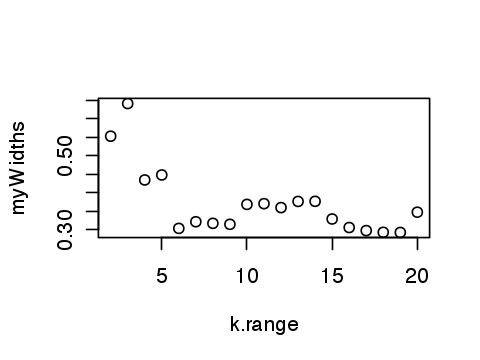

In [227]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(H_upregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [228]:
data = H_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=5)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [229]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


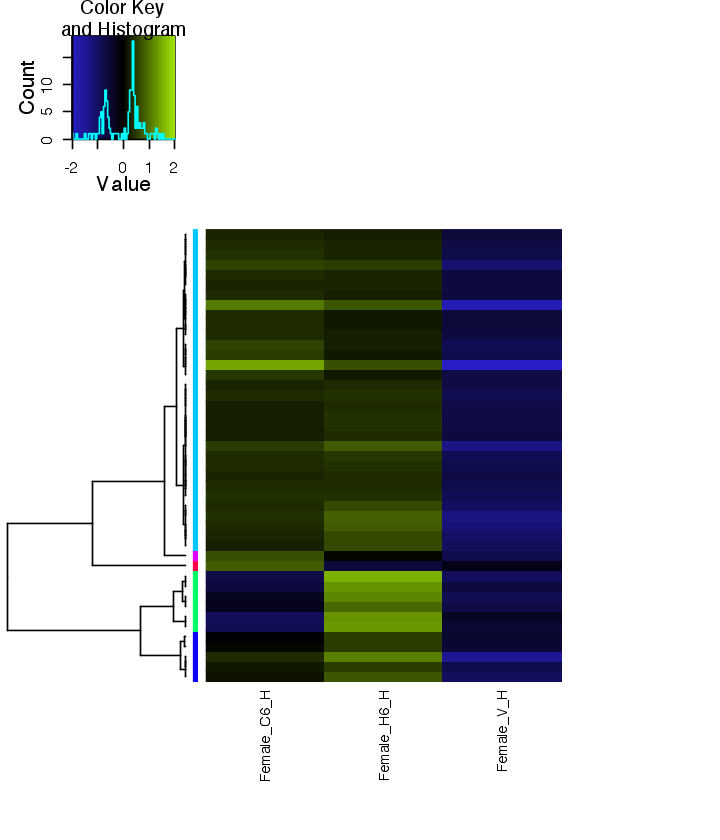

In [230]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [231]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_H_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [232]:
conSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_C6_H"))
hetSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_H6_H"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

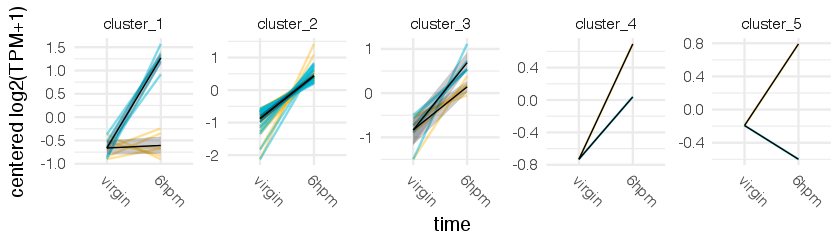

In [233]:
newSub$cluster = factor(newSub$cluster, levels = c(unique(newSub$cluster)))
options(repr.plot.width = 7, repr.plot.height = 2)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 1) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those two clusters here:

In [234]:
## Cluster 1
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C1.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C1.enrich_result_table$category, get_GO_term_descr))
C1.enrich_result_table$go_term = descr
write.table(C1.enrich_result_table, "Results/GO_analyses/GO_results-head_cluster1_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [235]:
## Cluster 2
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_2"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C2.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C2.enrich_result_table$category, get_GO_term_descr))
C2.enrich_result_table$go_term = descr
write.table(C2.enrich_result_table, "Results/GO_analyses/GO_results-head_cluster2_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [236]:
## Cluster 3
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_3"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C3.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C3.enrich_result_table$category, get_GO_term_descr))
C3.enrich_result_table$go_term = descr
write.table(C3.enrich_result_table, "Results/GO_analyses/GO_results-head_cluster3_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Let's look at GO enrichment across all upregulated genes:

In [237]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
enrich_result_table$factor = go_enrich_factor
write.table(enrich_result_table, "Results/GO_analyses/GO_results-head_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


##### Analysis of downregulated genes in the female head:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [238]:
H_downregulated_genes = unique(c(H_het.v.vir.list_down, H_con.v.vir.list_down))
message(paste("There are ", length(H_downregulated_genes), " downregulated genes", sep =""))
H_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% H_downregulated_genes)

H_downregulated_genes_matrix = H_downregulated_genes_matrix[ , grepl("_H$", names(H_downregulated_genes_matrix))]
H_downregulated_genes_matrix_con = subset(H_downregulated_genes_matrix, select = c("Female_V_H", "Female_C6_H"))
H_downregulated_genes_matrix_het = subset(H_downregulated_genes_matrix, select = c("Female_V_H", "Female_H6_H"))

There are 45 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

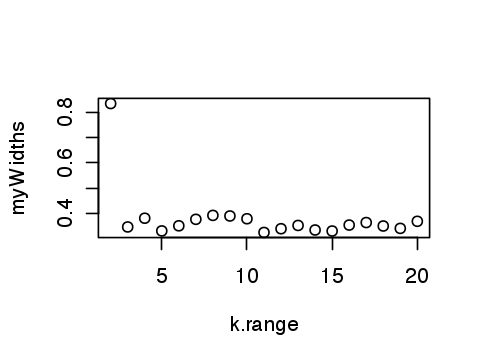

In [239]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(H_downregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [240]:
data = H_downregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=3)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [241]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


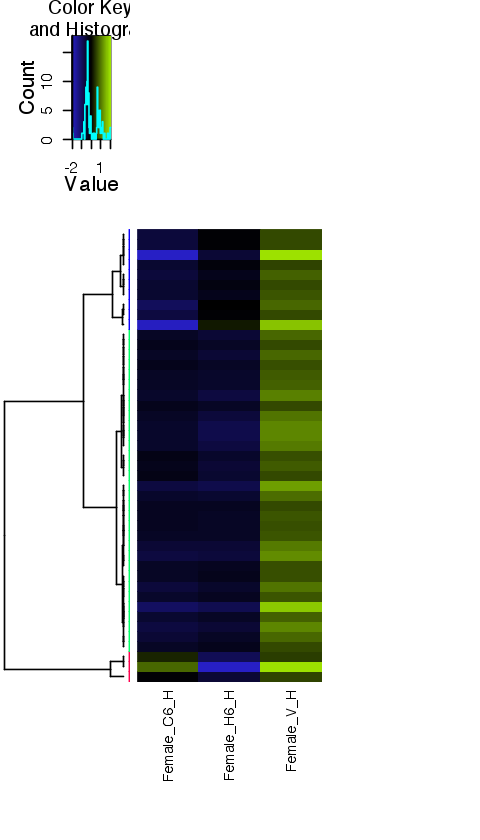

In [242]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 4, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [243]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_H_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [244]:
conSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_C6_H"))
hetSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_H6_H"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

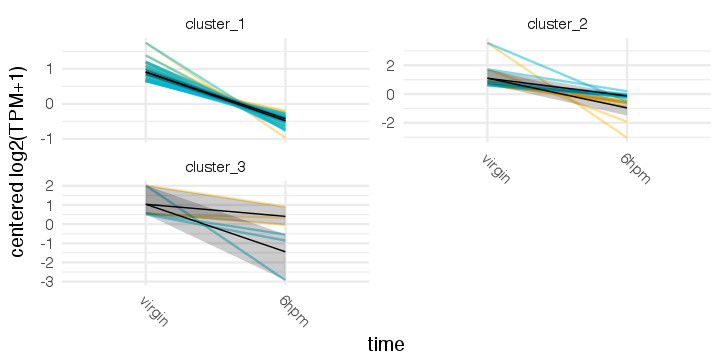

In [245]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those two clusters here:

In [246]:
## Cluster 1
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C1.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C1.enrich_result_table$category, get_GO_term_descr))
C1.enrich_result_table$go_term = descr
write.table(C1.enrich_result_table, "Results/GO_analyses/GO_results-head_cluster1_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [247]:
## Cluster 2
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_2"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C2.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C2.enrich_result_table$category, get_GO_term_descr))
C2.enrich_result_table$go_term = descr
write.table(C2.enrich_result_table, "Results/GO_analyses/GO_results-head_cluster2_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [248]:
## Cluster 3
cat_genes_vec = as.integer(features_with_GO %in% unique(newSub$Gene_ID[newSub$cluster == "cluster_3"]))
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
C3.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(C3.enrich_result_table$category, get_GO_term_descr))
C3.enrich_result_table$go_term = descr
write.table(C3.enrich_result_table, "Results/GO_analyses/GO_results-head_cluster3_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


Let's look at GO enrichment across all upregulated genes:

In [249]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
enrich_result_table$factor = go_enrich_factor
write.table(enrich_result_table, "Results/GO_analyses/GO_results-head_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


## Analysis of transferred mRNAs

We'll examine the transfer of mRNAs from heterospecific males to females by capturing genes that are upregulated at 3hpm. The majority of those are shared between the two conditions, but the heterospecific condition has more. So the union of both lists will suffice (73 in het alone, and 76 in the combined).

First we'll output the genes the are upregulated at 3hpm in both conspecific and heterospecific conditions. 

In [250]:
upAT3hpm.het.matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% union(DE.genes_H3.v.vir_up, DE.genes_C3.v.vir_up))
transfer.candidates = subset(upAT3hpm.het.matrix, Female_H3_RT > Female_V_RT & Female_H6_RT < Female_H3_RT)
colnames(transfer.candidates) = gsub("Female_", "", colnames(transfer.candidates))
transfer.candidates.male = subset(transfer.candidates, select = grepl("Male", colnames(transfer.candidates)))
transfer.candidates.RT = subset(transfer.candidates, select = grepl("RT", colnames(transfer.candidates)))
transfer.candidates = cbind(transfer.candidates.male, transfer.candidates.RT)
transfer.candidates.list = rownames(transfer.candidates)

Here we'll extract their transcript IDs, since that's what the mapping was against:

In [251]:
transfer.candidates.list.FBtr = filter(FBgn_to_FBtr, FBgn_ID %in% transfer.candidates.list)$FBtr

Write this out to a file:

In [252]:
write.table(transfer.candidates.list.FBtr, file = "Results/transferred.mRNA.candidates.IDs.FBtr.list", quote = F, row.names = F, col.names = F)

We can make a heatmap of those genes:

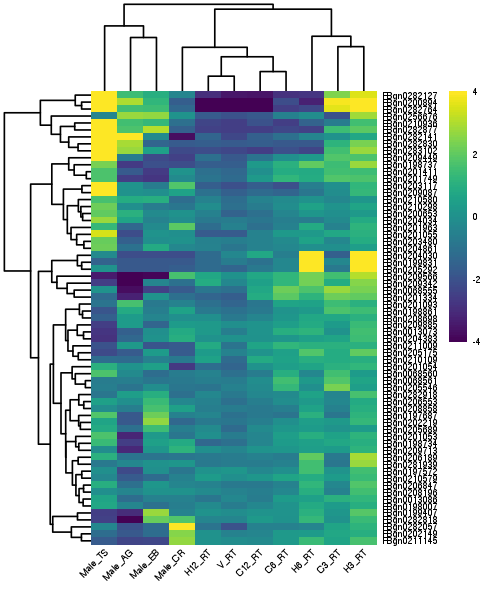

In [253]:
data = log2(transfer.candidates+1)
data = t(scale(t(data), scale=F))
data[data < -4] = -4
data[data > 4] = 4

options(repr.plot.width = 4, repr.plot.height = 5)
# pdf("Figures/tissue-biased_heatmap.pdf", width = 4, height = 5)
pheatmap(
  mat               = data,
  color             = viridis(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   annotation_row    = virgin.factor.labeling,
#   annotation_colors = mat_colors,
#   drop_levels       = TRUE,
#   annotation_names_row = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/tissue-biased_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 5    
)
# dev.off()

We'll use a SNP analysis comparing the conspecific and heterospecific samples to identify whether these are indeed transferred transcripts. To do this, we can use the dvir1.06 genome mapping and the _de novo_ transcriptome. For the latter, we'll output the corresponding PASA sequences from our Blast results, and also perform a DE test between 3hpm and virgin RT samples. First we'll output the homolg list:

In [254]:
transfer.candidates.gene_ids = unique(filter(geneID_to_fbgn, ref_gene_id %in% transfer.candidates.list)$gene_id)
transfer.candidates.transcript_ids = unique(filter(gene.features, gene_id %in% transfer.candidates.gene_ids)$transcript_id)
pasa.orthologs = as.character(unique(subset(pasa_v_annotated_blast, sseqid %in% transfer.candidates.transcript_ids)$qseqid))

For the DE test we need to do several things. First we'll create an RT-specific count matrix:

In [255]:
counts_bt2.pasa.RT = subset(counts_bt2.pasa, select=grepl("RT", colnames(counts_bt2.pasa)))
colnames(counts_bt2.pasa.RT) = gsub("Female_", "", colnames(counts_bt2.pasa.RT))
# counts_bt2.pasa.RT = subset(counts_bt2.pasa.RT, select=RT_GoodReps)

Now let's filter low expression genes within a minimum cpm of 5:

In [256]:
cpm_bt2.pasa.RT <- cpm(counts_bt2.pasa.RT)
thresh_RT.bt2.pasa <- cpm_bt2.pasa.RT > 5

countsKeep_RT.bt2.pasa <- rowSums(thresh_RT.bt2.pasa) >= 3
countsFiltered_bt2.pasa.RT <- counts_bt2.pasa.RT[countsKeep_RT.bt2.pasa,]

## Clean-up
rm(cpm_bt2.pasa.RT, countsKeep_RT.bt2.pasa, thresh_RT.bt2.pasa)

Create edgeR DE object and run glmFit

In [257]:
dgeList.pmv <- DGEList(counts = countsFiltered_bt2.pasa.RT, group = groups.pmv)
dgeList.pmv <- calcNormFactors(dgeList.pmv)
dgeList.pmv <- estimateCommonDisp(dgeList.pmv)
dgeList.pmv <- estimateTagwiseDisp(dgeList.pmv)
dgeList.pmv_fit <- glmFit(dgeList.pmv, design.pmv)

Now we'll run the contrasts between the 3hpm samples and the virgin sample:

In [258]:
glmT_C3.v.vir <- glmTreat(dgeList.pmv_fit, coef =3, lfc =1)
glmT_H3.v.vir <- glmTreat(dgeList.pmv_fit, coef =6, lfc =1)

Extract gene list of DE genes, first upregulated ones....

In [259]:
DE.genes_C3.v.vir_up <- rownames(subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1))
DE.genes_H3.v.vir_up <- rownames(subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1))

We'll capture the union of those two gene lists:

In [260]:
transfer.candidates.list.pasa = union(DE.genes_C3.v.vir_up, DE.genes_H3.v.vir_up)

We'll look at the overlap between the homology-based list and the DE-based list. First we'll get the PASA gene names:

In [261]:
transfer.candidates.list.pasa.transcripts = unique(filter(pasa_trans_map, V1 %in% transfer.candidates.list.pasa)$V2)

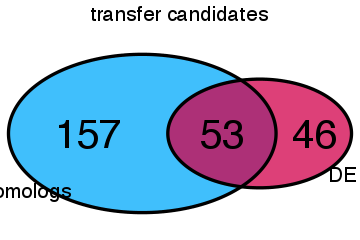

In [262]:
transCand.pasa_candidates <- list(DE = transfer.candidates.list.pasa.transcripts, homologs = pasa.orthologs)

transCand.pasa_Vdiag<-venn.diagram(transCand.pasa_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 1000)

transCand.pasa_combs <- unlist(lapply(1:length(transCand.pasa_candidates), function(j) combn(names(transCand.pasa_candidates), j, simplify = FALSE)), recursive = FALSE)
names(transCand.pasa_combs) <- sapply(transCand.pasa_combs, function(i) paste0(i, collapse = ","))
    
transCand.pasa_elements <- lapply(transCand.pasa_combs, function(i) Setdiff(transCand.pasa_candidates[i], transCand.pasa_candidates[setdiff(names(transCand.pasa_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
grid.arrange(gTree(children=transCand.pasa_Vdiag), top = "transfer candidates")

Write the list to a file:

In [263]:
write.table(unlist(transCand.pasa_elements), file = "Results/transferred.mRNA.candidates.IDs.pasa.list", quote = F, row.names = F, col.names = F)

Output individual gene plots for all transferred candidates:

In [264]:
# candidate_transferred_genome = suppressMessages(lapply(transfer.candidates.list, 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.fbgn, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_genome.pdf", marrangeGrob(grobs = candidate_transferred_genome, nrow = 3, ncol =1))

In [265]:
# candidate_transferred_pasa = suppressMessages(lapply(unique(filter(pasa_trans_map, V2 %in% unlist(transCand.pasa_elements))$V1), 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.pasa, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_pasa.pdf", marrangeGrob(grobs = candidate_transferred_pasa, nrow = 3, ncol =1))

##### Analysis of VCF output:

First load the VCF files for the genome and pasa analyses, and the SNPs inferred from the DNAseq data:

In [266]:
genome.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.FBtr.mrg/all_cat_merged_simplified.vcf", header = T, sep = "\t")
pasa.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.pasa.mrg/all_cat_merged_simplified.vcf", header = T, sep = "\t")
exon.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.FBtr.mrg/alignemnts/eXon.SNPs.vcf", header = T, sep = "\t")

add SNP ID and base character to the exon SNP object:

In [267]:
exon.vcf$SNP_id = paste(exon.vcf$CHROM, exon.vcf$POS, sep = "_")

Now we subset the relevant columns:

In [270]:
info.fields = subset(genome.vcf, select = c("CHROM", "POS","REF", "ALT", "QUAL", "DP"))
genotypes = subset(genome.vcf, select = c('C3_RT.bam.GT', 'H3_RT.bam.GT'))
colnames(genotypes) = gsub(".bam.GT", "", colnames(genotypes))
genome.vcf.data = cbind(info.fields, genotypes)
genome.vcf.data$SNP_id = paste(genome.vcf.data$CHROM, genome.vcf.data$POS, sep = "_")
genome.vcf.data = filter(genome.vcf.data, QUAL > 20)
# write.table(genome.vcf.data, "Trinity/pasa/transferred_transcripts/genome.transfer_candidates_subset.vcf", quote = F, sep = "\t", row.names = F)

Now merge the exon and genome results:

In [271]:
merged.vcf = merge(genome.vcf.data, exon.vcf, by.x = "SNP_id", by.y = "SNP_id", all.x = T)

Now output the candidate transferred mRNAs for the exon analysis:

In [272]:
exon.transfer.candidates = unique(filter(merged.vcf, as.character(C3_RT) != as.character(H3_RT) & !is.na(CHROM.y) & Dnov_4 != 1)$CHROM.x)

Also format the pasa vcf data:

In [273]:
info.fields = subset(pasa.vcf, select = c("CHROM", "POS","REF", "ALT", "QUAL", "DP"))
genotypes = subset(pasa.vcf, select = c('C3_RT.bam.GT', 'H3_RT.bam.GT'))
colnames(genotypes) = gsub(".bam.GT", "", colnames(genotypes))
pasa.vcf.data = cbind(info.fields, genotypes)
pasa.vcf.data$SNP_id = paste(pasa.vcf.data$CHROM, pasa.vcf.data$POS, sep = "_")
pasa.vcf.data = filter(pasa.vcf.data, QUAL > 20)
nrow(pasa.vcf.data)
head(pasa.vcf.data)
# write.table(pasa.vcf.data, "Trinity/pasa/transferred_transcripts/pasa.transfer_candidates_subset.vcf", quote = F, sep = "\t", row.names = F)

[1] 1686

CHROM,POS,REF,ALT,QUAL,DP,C3_RT,H3_RT,SNP_id
asmbl_10050,428,C,T,20.4535,1293,1/1,1/1,asmbl_10050_428
asmbl_10050,432,G,C,51.0000,1387,1/1,1/1,asmbl_10050_432
asmbl_10050,473,C,T,178.0000,3415,1/1,1/1,asmbl_10050_473
asmbl_10051,106,C,T,44.4146,1076,./.,1/1,asmbl_10051_106
asmbl_10051,110,G,C,44.4146,1076,./.,1/1,asmbl_10051_110
asmbl_10051,151,C,T,66.0000,1200,1/1,1/1,asmbl_10051_151


Make an object of SNPs with missing information:

In [274]:
genome.bad.SNPs = filter(genome.vcf.data, C3_RT == "./." | H3_RT == "./.")$SNP_id
pasa.bad.SNPs = filter(pasa.vcf.data, C3_RT == "./." | H3_RT == "./.")$SNP_id

Now we'll subset the VCF object to only include SNPs that are different between the con- and heterospecific samples:

In [275]:
filter(genome.vcf.data, SNP_id %!in% genome.bad.SNPs & as.character(C3_RT) != as.character(H3_RT))
genome.transfer.candidates = unique(filter(genome.vcf.data, SNP_id %!in% genome.bad.SNPs & as.character(C3_RT) != as.character(H3_RT))$CHROM)

CHROM,POS,REF,ALT,QUAL,DP,C3_RT,H3_RT,SNP_id
FBtr0229759,478,C,T,93.0000,1047,0/1,1/1,FBtr0229759_478
FBtr0229759,492,G,T,64.0000,996,0/1,1/1,FBtr0229759_492
FBtr0230684,88,C,"A,G",44.4182,90,1/1,2/2,FBtr0230684_88
FBtr0232780,966,T,C,228.0000,3381,1/1,0/1,FBtr0232780_966
FBtr0237898,332,A,G,110.0000,553,1/1,0/1,FBtr0237898_332
FBtr0237898,350,G,A,114.0000,437,1/1,0/1,FBtr0237898_350
FBtr0237898,370,A,G,136.0000,400,1/1,0/1,FBtr0237898_370
FBtr0237898,452,G,A,120.0000,462,1/1,0/1,FBtr0237898_452
FBtr0237898,470,G,C,93.0000,520,1/1,0/1,FBtr0237898_470
FBtr0237898,678,G,"A,T",102.0000,173,1/1,2/2,FBtr0237898_678


combine both result candidates:

In [276]:
combined.transfer.candidates = union(exon.transfer.candidates, genome.transfer.candidates)

Extract their gene names:

In [277]:
combined.transfer.candidates.FBgn = filter(FBgn_to_FBtr, FBtr_ID %in% combined.transfer.candidates)$FBgn

Make a heatmap of those genes:

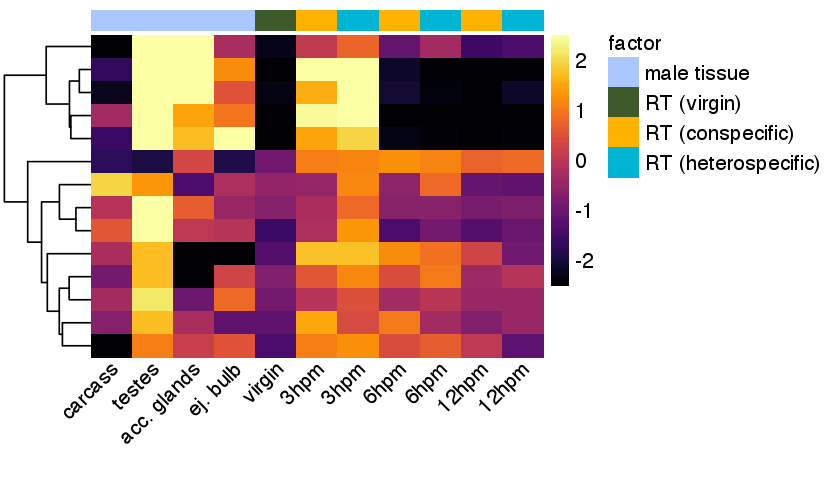

In [283]:
tmp = data.frame(sample = colnames(data))
tmp$factor = ifelse(grepl("Male", tmp$sample), "male tissue", ifelse(grepl("^C", tmp$sample), "RT (conspecific)", ifelse(grepl("^H", tmp$sample), "RT (heterospecific)", "RT (virgin)")))
rownames(tmp) = tmp$sample
tmp = subset(tmp, select = "factor")

mat_colors <- list(factor = c("#a8c8ff","#3f5a2a","#ffb200","#00b5d4"))
names(mat_colors$factor) <- unique(tmp$factor)

data = subset(transfer.candidates, rownames(transfer.candidates) %in% combined.transfer.candidates.FBgn)
col.order <- c("Male_CR","Male_TS","Male_AG","Male_EB","V_RT","C3_RT","H3_RT","C6_RT","H6_RT","C12_RT","H12_RT")
data = data[,col.order]
# colnames(data) <- c("carcass","Male_TS","Male_AG","Male_EB","V_RT","C3_RT","C6_RT","C12_RT","H3_RT","H6_RT","H12_RT")
data = log2(data+1)
data = t(scale(t(data), scale=F))
data[data < -2.5] = -2.5
data[data > 2.5] = 2.5

options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Figures/transferred_mRNAs_heatmap.pdf", width = 7, height = 4)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
  labels_col        = c("carcass","testes","acc. glands","ej. bulb","virgin","3hpm","3hpm","6hpm","6hpm","12hpm","12hpm"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
cluster_cols = F,
  annotation_col    = tmp,
  annotation_colors = mat_colors,
  drop_levels       = TRUE,
  annotation_names_col = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/transferred_mRNAs_heatmap.pdf",
#   width             = 7, 
#   height            = 4,
  fontsize          = 12    
)
# dev.off()

In [282]:
candidate_transferred_genome = suppressMessages(lapply(as.character(combined.transfer.candidates.FBgn), 
                                                       geneBoxPlot, 
                                                       object = filter(tpmTable_bt2.fbgn, Tissue == "repTract" | Sex == "male")))
ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_combined.pdf", marrangeGrob(grobs = candidate_transferred_genome, nrow = 3, ncol =1))

Saving 7 x 7 in image
